# Bioinformatics analysis of beta-sandwiches

## Imports

In [1]:
import copy
import itertools
import os
import pickle
import random
import scipy
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns  # Note will call statsmodels for kdeplot if installed on system, otherwise will use scipy
import statsmodels.api as sm
from collections import OrderedDict
from sklearn.cluster import KMeans

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Functions and variable definitions

In [2]:
"""
Defines dictionary of amino acid abbreviations
"""
aa_dict = OrderedDict({'A': 'Ala',
                       'R': 'Arg',
                       'N': 'Asn',
                       'D': 'Asp',
                       'C': 'Cys',
                       'Q': 'Gln',
                       'E': 'Glu',
                       'G': 'Gly', 
                       'H': 'His',
                       'I': 'Ile',
                       'L': 'Leu',
                       'K': 'Lys',
                       'M': 'Met',
                       'F': 'Phe',
                       'P': 'Pro',
                       'S': 'Ser',
                       'T': 'Thr',
                       'W': 'Trp',
                       'Y': 'Tyr',
                       'V': 'Val'})

In [3]:
#
def define_dict(dict_vals):
    """
    Defines a dictionary of amino acid properties. Allows quick definition of new property dictionaries (can
    simply copy and paste the new property values from e.g. the Amino Acid Index) 
    Input: a list (dict_vals) of property values for the 20 (alphabetically ordered) amino acids
    Returns: a dictionary of these property values
    """
    aa_dict = OrderedDict({'A': dict_vals[0],
                           'R': dict_vals[1],
                           'N': dict_vals[2],
                           'D': dict_vals[3],
                           'C': dict_vals[4],
                           'Q': dict_vals[5],
                           'E': dict_vals[6],
                           'G': dict_vals[7],
                           'H': dict_vals[8],
                           'I': dict_vals[9],
                           'L': dict_vals[10],
                           'K': dict_vals[11],
                           'M': dict_vals[12],
                           'F': dict_vals[13],
                           'P': dict_vals[14],
                           'S': dict_vals[15],
                           'T': dict_vals[16],
                           'W': dict_vals[17],
                           'Y': dict_vals[18],
                           'V': dict_vals[19]})
    return aa_dict

In [4]:
#
def remove_nan(prop_list):
    """
    Removes all instances of '', 'NaN' and np.nan from an input list
    Input: a list (prop_list) to be filtered
    Returns: the filtered list
    """
    prop_remove_list = ['', 'NaN', 'nan', np.nan]
    for prop_remove in prop_remove_list:
        while prop_remove in prop_list:
            prop_list.remove(prop_remove)
    return prop_list

In [5]:
#
def calc_indv_property_propensities(orig_df, prop, aa_dict):
    """
    Calculates propensities of the amino acids listed in the input dictionary for a (categorical) feature of
    interest (e.g. 'interior' or 'exterior')
    Input: dataframe of barrel / sandwich properties, name of the feature of interest (specified via the name of
           the corresponding column in the input dataframe), and dictionary of amino acid abbreviations
    Returns: dataframe of propensity values, plus dataframes of the frequencies and normalised frequencies (since
             extreme propensity values can result from low counts)
    """
    
    df = copy.deepcopy(orig_df)
    df = df[~df[prop].isin(['', 'NaN', 'nan', np.nan])]
    df = df.reset_index(drop=True)

    prop_list = list(set(df[prop].tolist()))
    prop_list = remove_nan(prop_list)

    temp_lists = {}
    for prop_val in prop_list:
        temp_lists['{}_propensity_list'.format(prop_val)] = ['']*len(list(aa_dict.keys()))
        temp_lists['{}_frequency_list'.format(prop_val)] = ['']*len(list(aa_dict.keys()))
        temp_lists['{}_normed_frequencies_list'.format(prop_val)] = ['']*len(list(aa_dict.keys()))

        temp_lists['total_{}_count'.format(prop_val)] = df[prop].tolist().count(prop_val)

    for index, aa in enumerate(list(aa_dict.keys())):
        aa_df = df[df['fasta_seq'] == aa]
        aa_df = aa_df.reset_index(drop=True)

        for prop_val in prop_list:
            temp_lists['{}_{}_count'.format(prop_val, aa)] = aa_df[prop].tolist().count(prop_val)

            if(
                min([temp_lists['{}_{}_count'.format(prop_val, aa)], temp_lists['total_{}_count'.format(prop_val)],
                     aa_df.shape[0], df.shape[0]]) > 0
            ):
                temp_lists['{}_frequency_list'.format(prop_val)][index] = copy.deepcopy(temp_lists['{}_{}_count'.format(prop_val, aa)])

                temp_lists['{}_{}_normed_frequencies'.format(prop_val, aa)] = (temp_lists['{}_{}_count'.format(prop_val, aa)]
                                                                             / temp_lists['total_{}_count'.format(prop_val)])
                temp_lists['{}_normed_frequencies_list'.format(prop_val)][index] = temp_lists['{}_{}_normed_frequencies'.format(prop_val, aa)]

                temp_lists['{}_{}_propensity'.format(prop_val, aa)] = ((temp_lists['{}_{}_normed_frequencies'.format(prop_val, aa)])
                                                                       / (aa_df.shape[0] / df.shape[0]))
                temp_lists['{}_propensity_list'.format(prop_val)][index] = temp_lists['{}_{}_propensity'.format(prop_val, aa)]
            else:
                temp_lists['{}_frequency_list'.format(prop_val)][index] = np.nan
                temp_lists['{}_normed_frequencies_list'.format(prop_val)][index] = np.nan
                temp_lists['{}_propensity_list'.format(prop_val)][index] = np.nan

    df_propensity_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    df_frequency_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    df_normed_frequencies_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    for prop_val in prop_list:
        df_propensity_dict[prop_val] = temp_lists['{}_propensity_list'.format(prop_val)]
        df_frequency_dict[prop_val] = temp_lists['{}_frequency_list'.format(prop_val)]
        df_normed_frequencies_dict[prop_val] = temp_lists['{}_normed_frequencies_list'.format(prop_val)]

    propensity_df = pd.DataFrame(df_propensity_dict)
    frequency_df = pd.DataFrame(df_frequency_dict)
    normed_frequencies_df = pd.DataFrame(df_normed_frequencies_dict)
    
    return propensity_df, frequency_df, normed_frequencies_df

In [6]:
#
def calc_combined_property_propensities(orig_df, props, aa_dict):
    """
    Calculates propensities of the amino acids listed in the input dictionary for two or more (categorical)
    features of interest (e.g. 'interior' and 'transmembrane', 'interior' and 'external', 'exterior' and
    'transmembrane', or 'exterior' and 'external')
    Input: dataframe of barrel / sandwich properties, list of names of the features of interest (specified via
           the names of the corresponding columns in the input dataframe), and dictionary of amino acid
           abbreviations
    Returns: dataframe of propensity values, plus dataframes of the frequencies and normalised frequencies (since
             extreme propensity values can result from low counts)
    """
    
    df = copy.deepcopy(orig_df)
    for prop in props:
        df = df[~df[prop].isin(['', 'NaN', 'nan', np.nan])]
        df = df.reset_index(drop=True)

    amalgamate_list = []
    for prop in props:
        filtered_list = list(set(df[prop].tolist()))
        amalgamate_list.append(filtered_list)
    combinations = list(itertools.product(*amalgamate_list))
    combinations = ['_'.join(tup) for tup in combinations]

    for prop in props:
        df[prop] = [str(x) for x in df[prop].tolist()]
    df_props = pd.DataFrame({'combination': df[props].apply('_'.join, axis=1),
                             'FASTA': df['fasta_seq']})

    temp_lists = {}
    for combination in combinations:
        temp_lists['{}_propensity_list'.format(combination)] = ['']*len(list(aa_dict.keys()))
        temp_lists['{}_frequency_list'.format(combination)] = ['']*len(list(aa_dict.keys()))
        temp_lists['{}_normed_frequencies_list'.format(combination)] = ['']*len(list(aa_dict.keys()))

        temp_lists['total_{}_count'.format(combination)] = df_props['combination'].tolist().count(combination)

        for index, aa in enumerate(list(aa_dict.keys())):
            aa_df = df_props[df_props['FASTA'] == aa]
            aa_df = aa_df.reset_index(drop=True)
            
            temp_lists['{}_{}_count'.format(combination, aa)] = aa_df['combination'].tolist().count(combination)
            if (
                min([temp_lists['{}_{}_count'.format(combination, aa)],
                     temp_lists['total_{}_count'.format(combination)], aa_df.shape[0], df.shape[0]]) > 0
            ):
                temp_lists['{}_frequency_list'.format(combination)][index] = copy.deepcopy(temp_lists['{}_{}_count'.format(combination, aa)])

                temp_lists['{}_{}_normed_frequencies'.format(combination, aa)] = (temp_lists['{}_{}_count'.format(combination, aa)]
                                                                                / temp_lists['total_{}_count'.format(combination)])
                temp_lists['{}_normed_frequencies_list'.format(combination)][index] = temp_lists['{}_{}_normed_frequencies'.format(combination, aa)]

                temp_lists['{}_{}_propensity'.format(combination, aa)] = ((temp_lists['{}_{}_normed_frequencies'.format(combination, aa)])
                                                                          / (aa_df.shape[0] / df_props.shape[0]))
                temp_lists['{}_propensity_list'.format(combination)][index] = temp_lists['{}_{}_propensity'.format(combination, aa)]
            else:
                temp_lists['{}_frequency_list'.format(combination)][index] = np.nan
                temp_lists['{}_normed_frequencies_list'.format(combination)][index] = np.nan
                temp_lists['{}_propensity_list'.format(combination)][index] = np.nan

    df_propensity_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    df_frequency_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    df_normed_frequencies_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    for combination in combinations:
        df_propensity_dict[combination] = temp_lists['{}_propensity_list'.format(combination)]
        df_frequency_dict[combination] = temp_lists['{}_frequency_list'.format(combination)]
        df_normed_frequencies_dict[combination] = temp_lists['{}_normed_frequencies_list'.format(combination)]

    propensity_df = pd.DataFrame(df_propensity_dict)
    frequency_df = pd.DataFrame(df_frequency_dict)
    normed_frequencies_df = pd.DataFrame(df_normed_frequencies_dict)

    return propensity_df, frequency_df, normed_frequencies_df

In [7]:
#
def gen_neighbouring_pairs_list(sub_df, domain_res_df, interaction, aa_dict, *args):
    """
    Makes a list of the amino acids in the input dataframe that form pairwise interactions at a particular
    location (e.g. HB vs. NHB positions) or via a particular type of interaction (e.g. cation-pi, hydrogen
    bonds, van der Waals interactions, etc.)
    Input: dataframe of barrel / sandwich properties, list of the residue ids in the domain, name of the
           interaction type / location of interest (specified via the name of the corresponding column in the
           input dataframe), dictionary of amino acid abbreviations, and list of properties against which to
           measure the amino acid pairs (e.g. phi and psi)
    Returns: list of interacting amino acid pairs, and (if args) dictionaries of args values for amino acid
             pairs
    """
    full_df = copy.deepcopy(domain_res_df)
    
    if args:
        props = list(args)
        
    domain_res_ids_list = []
    for row in range(full_df.shape[0]):
        domain_res_id = full_df['domain_ids'][row] + full_df['res_ids'][row]
        domain_res_ids_list.append(domain_res_id)

    neighbouring_pairs_list = []
    repeat_pairs_list = []
    if args:
        props_dict = OrderedDict()
        for prop in props:
            props_dict[prop] = OrderedDict()

    for row in range(sub_df.shape[0]):
        domain_res_id_1 = sub_df['domain_ids'][row] + sub_df['res_ids'][row]

        aa_1 = sub_df['fasta_seq'][row]
        if args:
            prop_val_1_list = ['']*len(props)
            for index, prop in enumerate(props):
                prop_val_1_list[index] = sub_df[prop][row]

        interaction_list = sub_df[interaction][row]
        if type(interaction_list) != list:
            interaction_list = [interaction_list]
        for res_id_2 in interaction_list:
            domain_res_id_2 = sub_df['domain_ids'][row] + res_id_2

            # Only considers amino acid pairs in which both (canonical) amino acids are located in the domain
            if domain_res_id_2 in domain_res_ids_list:
                res_id_2_index = domain_res_ids_list.index(domain_res_id_2)
                aa_2 = full_df['fasta_seq'][res_id_2_index]
                if args:
                    prop_val_2_list = ['']*len(props)
                    for index, prop in enumerate(props):
                        prop_val_2_list[index] = full_df[prop][res_id_2_index]

                if (
                        aa_1 in list(aa_dict.keys())
                    and aa_2 in list(aa_dict.keys())
                    and (not [domain_res_id_1, domain_res_id_2] in repeat_pairs_list)
                    and (not [domain_res_id_2, domain_res_id_1] in repeat_pairs_list)
                ):  # Each amino acid pair is counted once.
                    repeat_pairs_list.append([domain_res_id_1, domain_res_id_2])
                    repeat_pairs_list.append([domain_res_id_2, domain_res_id_1])

                    neighbouring_pairs_list.append('{}_{}'.format(aa_1, aa_2))
                    
                    if args:
                        for index, prop in enumerate(props):
                            prop_val_1 = prop_val_1_list[index]
                            prop_val_2 = prop_val_2_list[index]
                            # Must include domain id in key to ensure it is unique
                            props_dict[prop]['{}_{}_{}_{}'.format(domain_res_id_1, domain_res_id_2, aa_1, aa_2)] = [
                                prop_val_1, prop_val_2
                            ]
                            props_dict[prop]['{}_{}_{}_{}'.format(domain_res_id_2, domain_res_id_1, aa_2, aa_1)] = [
                                prop_val_2, prop_val_1
                            ]
    if args:
        return neighbouring_pairs_list, props_dict
    else:
        return neighbouring_pairs_list


#
def calc_aa_pair_propensities(neighbouring_pairs_list, aa_dict):
    """
    Calculates propensities of amino acids at a particular location to interact with one another
    Input: list of interacting amino acid pairs output from gen_neighbouring_pairs_list, and dictionary of amino
           acid abbreviations
    Returns: dataframe of propensity values, plus dataframes of the frequencies and normalised frequencies (since
             extreme propensity values can result from low counts)
    """
    # Each amino acid pair is counted in both orientations. (Note this is because positions 1 and 2 must be
    # treated independently (position 1 = object, position 2 = property of object) in the propensity calculations,
    # whereas these pairs do not have such an associated order and so must be listed in both orientations. See
    # lab notes for further details.)
    neighbouring_pairs_list = [['{}_{}'.format(aa_pair[0:1], aa_pair[-1:]), '{}_{}'.format(aa_pair[-1:], aa_pair[0:1])]
                               for aa_pair in neighbouring_pairs_list]
    neighbouring_pairs_list = [aa_pair for aa_pair_list in neighbouring_pairs_list for aa_pair in aa_pair_list]

    # Calculates propensity values
    all_pairs_count = len(neighbouring_pairs_list)
    temp_lists = {}

    for aa_1 in list(aa_dict.keys()):
        temp_lists['{}_propensity_list'.format(aa_1)] = ['']*len(list(aa_dict.keys()))
        temp_lists['{}_frequency_list'.format(aa_1)] = ['']*len(list(aa_dict.keys()))
        temp_lists['{}_normed_frequencies_list'.format(aa_1)] = ['']*len(list(aa_dict.keys()))

        # Calculates propensity for aa_1 to interact with aa_2 relative to all other amino acid possibilities
        # (= (aa_1_aa_2_count / aa_1_count) / (aa_2_count / all_aa_count)). 
        for aa_2_index, aa_2 in enumerate(list(aa_dict.keys())):
            aa_1_count = 0
            aa_2_count = 0
            aa_1_aa_2_count = 0

            for aa_pair in neighbouring_pairs_list:
                if aa_1 == aa_pair[0:1]:
                    aa_1_count += 1
                if aa_2 == aa_pair[-1:]:
                    aa_2_count += 1
                if aa_1 == aa_pair[0:1] and aa_2 == aa_pair[-1:]:
                    aa_1_aa_2_count += 1

            if min([all_pairs_count, aa_1_count, aa_2_count, aa_1_aa_2_count]) > 0:
                aa_1_aa_2_frequency = copy.deepcopy(aa_1_aa_2_count)
                temp_lists['{}_frequency_list'.format(aa_1)][aa_2_index] = aa_1_aa_2_frequency

                aa_1_aa_2_normed_frequencies = aa_1_aa_2_count / aa_1_count
                temp_lists['{}_normed_frequencies_list'.format(aa_1)][aa_2_index] = aa_1_aa_2_normed_frequencies

                aa_1_aa_2_propensity = ((aa_1_aa_2_count / aa_1_count)
                                        / (aa_2_count / all_pairs_count))
                temp_lists['{}_propensity_list'.format(aa_1)][aa_2_index] = aa_1_aa_2_propensity
            else:
                temp_lists['{}_frequency_list'.format(aa_1)][aa_2_index] = np.nan
                temp_lists['{}_normed_frequencies_list'.format(aa_1)][aa_2_index] = np.nan
                temp_lists['{}_propensity_list'.format(aa_1)][aa_2_index] = np.nan

    # The propensity for aa_1 to interact with aa_2 should equal the propensity for aa_2 to interact with aa_1
    for aa_1_index, aa_1 in enumerate(list(aa_dict.keys())):
        for aa_2_index, aa_2 in enumerate(list(aa_dict.keys())):
            propensity_12 = temp_lists['{}_propensity_list'.format(aa_1)][aa_2_index]
            propensity_21 = temp_lists['{}_propensity_list'.format(aa_2)][aa_1_index]

            if not np.isnan(propensity_12) and not np.isnan(propensity_21):
                if propensity_12 - propensity_21 > 0.0001:
                    sys.exit('Error with propensity calculation: {}{} ({}) != {}{} ({})'.format(
                        aa_1, aa_2, propensity_12, aa_2, aa_1, propensity_21
                    ))

    df_propensity_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    df_frequency_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    df_normed_frequencies_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    # FASTA label on heatmap refers to aa_2 (although propensity and frequency heatmaps will be symmetric about
    # their central axes)
    for aa_1 in list(aa_dict.keys()):
        df_propensity_dict[aa_1] = temp_lists['{}_propensity_list'.format(aa_1)]
        df_frequency_dict[aa_1] = temp_lists['{}_frequency_list'.format(aa_1)]
        df_normed_frequencies_dict[aa_1] = temp_lists['{}_normed_frequencies_list'.format(aa_1)]

    propensity_df = pd.DataFrame(df_propensity_dict)
    frequency_df = pd.DataFrame(df_frequency_dict)
    normed_frequencies_df = pd.DataFrame(df_normed_frequencies_dict)

    return propensity_df, frequency_df, normed_frequencies_df

In [8]:
#
def calc_voronoi_points(orig_df, cont_prop_1, cont_prop_2, min_cluster_size=25, save_file=False, file_name=''):
    """
    Calculates cluster centres for discretisation of 2D property space.
    Input: dataframe of barrel / sandwich properties, first (continuous) property of interest (specified via the
           name of the correspoing column in the input dataframe), second (continuous) property of interest
           (specified via the name of the correspoing column in the input dataframe), the minimum number of
           data points to be included in a cluster (default 25), plus whether to save a copy of the voronoi point
           plot and if so what file name to save it under
    Returns: numpy array of cluster coordinates, plus dataframe of cluster properties
    """
    
    df = copy.deepcopy(orig_df)
    df = df[  (~df[cont_prop_1].isin(['', 'NaN', 'nan', np.nan]))
            & (~df[cont_prop_2].isin(['', 'NaN', 'nan', np.nan]))]
    df = df.reset_index(drop=True)

    prop_array = []
    for row in range(df.shape[0]):
        prop_array.append([df[cont_prop_1][row], df[cont_prop_2][row]])
    prop_array = np.array(prop_array)

    kmeans = KMeans(n_clusters=200).fit(prop_array)

    if kmeans.n_iter_ >= 300:
        sys.exit('Clustering failed to converge')

    else:
        cluster_coords = kmeans.cluster_centers_

        cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
        cluster_sizes = cluster_sizes[1]

        smallest_cluster_size = cluster_sizes.min()
        while smallest_cluster_size < min_cluster_size:
            smallest_cluster_index = np.abs(cluster_sizes).argmin()
            smallest_cluster_coords = cluster_coords[smallest_cluster_index]

            distances = np.sqrt(np.sum(np.square(cluster_coords-smallest_cluster_coords), axis=1))
            distances[smallest_cluster_index] = 1e10
            closest_cluster_index = np.abs(distances).argmin()
            closest_cluster_size = cluster_sizes[closest_cluster_index]

            cluster_sizes[closest_cluster_index] = closest_cluster_size + smallest_cluster_size
            cluster_sizes = np.delete(cluster_sizes, smallest_cluster_index)
            cluster_coords = np.delete(cluster_coords, smallest_cluster_index, axis=0)

            smallest_cluster_size = cluster_sizes.min()

        plt.clf()
        plt.figure(figsize=(15, 15))
        plt.scatter(prop_array[:,0], prop_array[:,1], alpha=0.1)
        plt.scatter(cluster_coords[:,0], cluster_coords[:,1], color='k')
        plt.xlim(([-180, 180]))
        plt.ylim(([-180, 180]))
        plt.xticks(np.arange(-180, 210, 30))
        plt.yticks(np.arange(-180, 210, 30))
        if save_file is True:
            plt.savefig('{}.svg'.format(file_name))
        plt.show()

        cluster_df = pd.DataFrame({'Cluster size': cluster_sizes,
                                   '{}'.format(cont_prop_1): cluster_coords[:,0],
                                   '{}'.format(cont_prop_2): cluster_coords[:,1]})

        return cluster_coords, cluster_df


#
def calc_discrete_2d_indv_aa_propensities(orig_df, cont_prop_1, cont_prop_2, aa_dict, cluster_coords):
    """
    Calculates amino acid propensity values for bins in 2D property space.
    Input: dataframe of barrel / sandwich properties, first (continuous) property of interest (specified via the
           name of the corresponding column in the input dataframe), second (continuous) property of interest
           (specified via the name of the corresponding column in the input dataframe), dictionary of amino acid
           abbreviations, and coordinates of cluster centres
    Returns: dataframe of propensity values, plus dataframes of frequency and normalised frequency values (since
             propensity values can be skewed by very small sample sizes)
    """
    
    df = copy.deepcopy(orig_df)
    df = df[  (~df[cont_prop_1].isin(['', 'NaN', 'nan', np.nan]))
            & (~df[cont_prop_2].isin(['', 'NaN', 'nan', np.nan]))]
    df = df.reset_index(drop=True)

    propensity_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    frequency_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    normed_frequencies_dict = OrderedDict({'FASTA': list(aa_dict.keys())})
    voronoi_class_dict = OrderedDict()

    for voronoi_index in range(cluster_coords.shape[0]):
        voronoi_class_dict[voronoi_index] = [0]*(len(aa_dict)+1)
        propensity_dict[voronoi_index] = [np.nan]*len(aa_dict)
        frequency_dict[voronoi_index] = [np.nan]*len(aa_dict)
        normed_frequencies_dict[voronoi_index] = [np.nan]*len(aa_dict)

    for row in range(df.shape[0]):
        fasta = df['fasta_seq'][row]
        aa_index = list(aa_dict.keys()).index(fasta)

        val_1 = df[cont_prop_1][row]
        val_2 = df[cont_prop_2][row]
        prop_vals = np.array([val_1, val_2])

        distances = np.sqrt(np.sum(np.square(cluster_coords-prop_vals), axis=1))
        voronoi_index = np.abs(distances).argmin()
        voronoi_class_dict[voronoi_index][aa_index] += 1
        voronoi_class_dict[voronoi_index][-1] +=1

    for voronoi_index in list(voronoi_class_dict.keys()):
        for aa_index, aa in enumerate(list(aa_dict.keys())):
            class_aa_count = voronoi_class_dict[voronoi_index][aa_index]
            class_all_aas_count = voronoi_class_dict[voronoi_index][-1]

            total_aa_count = 0
            for voronoi_class_list in list(voronoi_class_dict.values()):
                total_aa_count += voronoi_class_list[aa_index]

            if min(class_aa_count, class_all_aas_count, total_aa_count, df.shape[0]) > 0:
                frequency_dict[voronoi_index][aa_index] = copy.deepcopy(class_aa_count)
                normed_frequencies_dict[voronoi_index][aa_index] = class_aa_count / class_all_aas_count
                propensity_dict[voronoi_index][aa_index] = (  (class_aa_count / class_all_aas_count)
                                                            / (total_aa_count / df.shape[0]))
            else:
                pass

    propensity_df = pd.DataFrame(propensity_dict)
    frequency_df = pd.DataFrame(frequency_dict)
    normed_frequencies_df = pd.DataFrame(normed_frequencies_dict)

    return propensity_df, frequency_df, normed_frequencies_df

In [9]:
#
def bootstrap_discrete_propensities(df, domain_res_df, prop, aa_dict, num_bootstrap_samples,
                                    propensity_calc_func, cluster_coords=[]):
    """
    Calculates 95% confidence limits about propensity values calculated for discrete categorical features
    Input: dataframe of barrel / sandwich properties, list of the residue ids in the domain, name(s) of the
           feature(s) of interest (specified via a name / list of names of the corresponding column(s) in the
           input dataframe, dictionary of amino acid abbreviations, the number of bootstrap samples to collect,
           the name of the propensity calculation function (calc_indv_property_propensities,
           calc_combined_property_propensities, calc_aa_pair_propensities, or
           calc_discrete_2d_indv_aa_propensities), and the coordinates of each cluster centre (if calculating
           propensities for bins in 2D property space, e.g. phi vs. psi)
    Returns: dictionary of bootstrapped propensity values, plus dictionaries of the bootstrapped frequencies
             and normalised frequencies (since extreme propensity values can result from low counts)
    """
    if propensity_calc_func == calc_indv_property_propensities:
        prop_vals = list(set(df[prop].tolist()))
        prop_vals = remove_nan(prop_vals)

    elif propensity_calc_func == calc_combined_property_propensities:
        prop_vals = []
        for sub_prop in prop:
            vals = list(set(df[sub_prop].tolist()))
            vals = remove_nan(vals)
            prop_vals.append(vals)
        prop_vals = list(itertools.product(*prop_vals))
        prop_vals = ['_'.join(tup) for tup in prop_vals]

    elif propensity_calc_func == calc_aa_pair_propensities:
        prop_vals = list(aa_dict.keys())
        neighbouring_pairs_list = gen_neighbouring_pairs_list(df, domain_res_df, prop, aa_dict)

    elif propensity_calc_func == calc_discrete_2d_indv_aa_propensities:
        prop_vals = [num for num in range(cluster_coords.shape[0])]

    aa_list = list(aa_dict.keys())

    bootstrap_propensities_dict = OrderedDict({'FASTA': aa_list})
    bootstrap_frequencies_dict = OrderedDict({'FASTA': aa_list})
    bootstrap_normed_frequencies_dict = OrderedDict({'FASTA': aa_list})

    for prop_val in prop_vals:
        bootstrap_propensities_dict[prop_val] = [([np.nan]*num_bootstrap_samples) for i in range(len(aa_list))]
        bootstrap_frequencies_dict[prop_val] = [([np.nan]*num_bootstrap_samples) for i in range(len(aa_list))]
        bootstrap_normed_frequencies_dict[prop_val] = [([np.nan]*num_bootstrap_samples) for i in range(len(aa_list))]

    for num_1 in range(num_bootstrap_samples):
        if propensity_calc_func in [calc_indv_property_propensities, calc_combined_property_propensities,
                                    calc_discrete_2d_indv_aa_propensities]:
            # Samples input dataframe with replacement
            indices = []
            for num_2 in range(df.shape[0]):
                random_num = random.randint(0, (df.shape[0]-1))
                indices.append(random_num)
            new_df = copy.deepcopy(df).iloc[indices]
            new_df = new_df.reset_index(drop=True)

            if propensity_calc_func in [calc_indv_property_propensities, calc_combined_property_propensities]:
                propensity_df, frequency_df, normed_frequencies_df = propensity_calc_func(
                    new_df, prop, aa_dict
                )
            elif propensity_calc_func == calc_discrete_2d_indv_aa_propensities:
                propensity_df, frequency_df, normed_frequencies_df = propensity_calc_func(
                    new_df, prop[0], prop[1], aa_dict, cluster_coords
                )

        elif propensity_calc_func == calc_aa_pair_propensities:
            # Samples neighbouring_pairs_list with replacement
            resampled_pairs_list = random.choices(neighbouring_pairs_list, k=len(neighbouring_pairs_list))
            
            propensity_df, frequency_df, normed_frequencies_df = propensity_calc_func(
                resampled_pairs_list, aa_dict
            )

        for prop_val in prop_vals:
            for index, num_3 in enumerate(propensity_df[prop_val].tolist()):
                bootstrap_propensities_dict[prop_val][index][num_1] = propensity_df[prop_val][index]
                bootstrap_frequencies_dict[prop_val][index][num_1] = frequency_df[prop_val][index]
                bootstrap_normed_frequencies_dict[prop_val][index][num_1] = normed_frequencies_df[prop_val][index]

    return bootstrap_propensities_dict, bootstrap_frequencies_dict, bootstrap_normed_frequencies_dict

In [10]:
#
def plot_bar_graphs(df, propensity_or_frequency, save_file=True, file_name=''):
    """
    Plots a bar graph of property / propensity of interest vs. amino acid identity
    Input: dataframe of barrel / sandwich properties, and string defining whether the input dataframe contains
           propensity, frequency or normalised frequency values, whether to save a copy of the plot and if so
           the file name to use
           (specified via the name of the corresponding column in the input dataframe)
    """
    reshaped_df = pd.melt(df, id_vars='FASTA', var_name='Property', value_name=propensity_or_frequency)
    reshaped_df = reshaped_df.dropna()
    reshaped_df = reshaped_df.reset_index(drop=True)

    plt.clf()
    sns.catplot(
        x='FASTA', y=propensity_or_frequency, hue='Property', data=reshaped_df, kind='bar', height=5, aspect=3,
        legend=False
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    if save_file is True:
        plt.savefig('{}.svg'.format(file_name))
    plt.show()

In [11]:
#
def gen_95_conf_intervals(bootstrap_propensity_dict, propensity_or_frequency, middle=False):
    """
    Calculates 95% confidence intervals from bootstrapped sample.
    Input: dictionary of bootstrapped propensity values, and string defining whether the input dataframe contains
           propensity, frequency or normalised frequency values
    Returns: dictionary of lower percentile propensity values, dictionary of upper percentile propensity values
    """
    aa_list = bootstrap_propensity_dict['FASTA']
    
    lower_percentile_dict = OrderedDict({'FASTA': aa_list})
    upper_percentile_dict = OrderedDict({'FASTA': aa_list})
    if middle is True:
        middle_percentile_dict = OrderedDict({'FASTA': aa_list})

    for prop_val in list(bootstrap_propensity_dict.keys()):
        if prop_val != 'FASTA':
            lower_percentile_dict[prop_val] = [np.nan]*len(aa_list)
            upper_percentile_dict[prop_val] = [np.nan]*len(aa_list)
            if middle is True:
                middle_percentile_dict[prop_val] = [np.nan]*len(aa_list)

            for index, propensity_list in enumerate(bootstrap_propensity_dict[prop_val]):
                propensity_list = [val for val in propensity_list if not np.isnan(val)]
                if propensity_list:
                    lower_percentile = np.percentile(propensity_list, 2.5)
                    upper_percentile = np.percentile(propensity_list, 97.5) 
                    middle_percentile = np.percentile(propensity_list, 50)
                else:
                    lower_percentile = np.nan
                    upper_percentile = np.nan
                    middle_percentile = np.nan

                lower_percentile_dict[prop_val][index] = lower_percentile
                upper_percentile_dict[prop_val][index] = upper_percentile
                if middle is True:
                    middle_percentile_dict[prop_val][index] = middle_percentile

    if middle is False:
        return lower_percentile_dict, upper_percentile_dict
    if middle is True:
        return lower_percentile_dict, upper_percentile_dict, middle_percentile_dict


#
def plot_bar_graphs_with_conf_limits(bootstrap_df, lower_percentile_dict, upper_percentile_dict,
                                     propensity_or_frequency, save_file=False, file_name=''):
    """
    Plots a bar graph of property / propensity of interest vs. amino acid identity with bootstrapped 95%
    confidence limits
    Input: dataframe of initial propensity values, dataframe of bootstrapped lower percentile values, dataframe
           of bootstrapped upper percentile values, and string defining whether the input dataframe contains
           propensity, frequency or normalised frequency values, whether to save the plot and if so the file
           name to use
    """
    reshaped_df = pd.melt(bootstrap_df, id_vars='FASTA', var_name='Property', value_name=propensity_or_frequency)
    na_indices = list(np.where(reshaped_df[propensity_or_frequency].notnull())[0])
    reshaped_df = reshaped_df.iloc[na_indices].reset_index(drop=True)

    lower_percentile_df = pd.DataFrame(lower_percentile_dict)
    lower_percentile_df = pd.melt(lower_percentile_df, id_vars='FASTA', var_name='Property',
                                  value_name=propensity_or_frequency)
    lower_percentile_df = lower_percentile_df.iloc[na_indices].reset_index(drop=True)

    upper_percentile_df = pd.DataFrame(upper_percentile_dict)
    upper_percentile_df = pd.melt(upper_percentile_df, id_vars='FASTA', var_name='Property',
                                  value_name=propensity_or_frequency)
    upper_percentile_df = upper_percentile_df.iloc[na_indices].reset_index(drop=True)

    # Plots bar graph with confidence limits
    num_prop = len(set(reshaped_df['Property'].tolist()))
    if num_prop <= 10:
        palette = 'dark'
    else:
        palette = ['black']
    plt.clf()
    plt.figure(figsize=(15,8))
    sns.barplot(x='FASTA', y=propensity_or_frequency, hue='Property', data=reshaped_df)
    sns.stripplot(x='FASTA', y=propensity_or_frequency, hue='Property', data=lower_percentile_df,
                  jitter=False, dodge=True, palette=palette)
    sns.stripplot(x='FASTA', y=propensity_or_frequency, hue='Property', data=upper_percentile_df,
                  jitter=False, dodge=True, palette=palette)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    if save_file is True:
        plt.savefig('{}.svg'.format(file_name))
    plt.show()

In [12]:
#
def iterate_bootstrap_propensities(df, domain_res_df, prop, aa_dict, bootstrap_samples_list,
                                   propensity_calc_func, propensity_df, frequency_df, cluster_coords=[]):
    """
    Calculates 95% confidence limits about propensity, frequency and normalised frequency values calculated for
    discrete categorical features whilst varying the size of the bootstrap population (to determine the minimum
    number of bootstrap samples required to obtain an accurate estimate of the confidence limits)
    Input: dataframe of barrel / sandwich properties, list of the residue ids in the domain, name(s) of the
           feature(s) of interest (specified via a name / list of names of the corresponding column(s) in the
           input dataframe), dictionary of amino acid abbreviations, list of number of bootstrap samples to use
           in the confidence limit calculation, name of the propensity calculation function
           (calc_indv_property_propensities, calc_combined_property_propensities, calc_aa_pair_propensities,
           or calc_discrete_2d_indv_aa_propensities), dataframe of (non-bootstrapped) propensity values, dataframe
           of (non-bootstrapped) frequency values, dataframe of (non-bootstrapped) normalised frequency values,
           and the coordinates of each cluster centre (if calculating propensities for bins in 2D property space,
           e.g. phi vs. psi)
    Returns: dictionaries of propensity, frequency and normalised frequency values vs. number of bootstrap samples
    """
    dfs = {'Propensity': propensity_df,
           'Frequency': frequency_df}

    iterated_dicts = {'Propensity': OrderedDict(),
                      'Frequency': OrderedDict()}

    for num in bootstrap_samples_list:
        print(num)
        (bootstrap_propensities_dict, bootstrap_frequencies_dict, bootstrap_normed_frequencies_dict
        ) = bootstrap_discrete_propensities(
            df, domain_res_df, prop, aa_dict, num, propensity_calc_func, cluster_coords
        )
        bootstrapped_dicts = {'Propensity': bootstrap_propensities_dict,
                              'Frequency': bootstrap_frequencies_dict}

        for output_type, iterated_dict in iterated_dicts.items():
            bootstrap_dict = bootstrapped_dicts[output_type]
            
            if propensity_calc_func in [calc_indv_property_propensities, calc_combined_property_propensities,
                                        calc_aa_pair_propensities]:
                lower_percentile, upper_percentile = gen_95_conf_intervals(
                    bootstrap_dict, output_type
                )
            elif propensity_calc_func == calc_discrete_2d_indv_aa_propensities:
                lower_percentile, upper_percentile, middle_percentile = gen_95_conf_intervals(
                    bootstrap_dict, output_type, middle=True
                )
            iterated_dict[num] = OrderedDict({'FASTA': list(aa_dict.keys())})

            for prop_val in list(bootstrap_dict.keys()):
                if prop_val != 'FASTA':
                    iterated_dict[num][prop_val] = ['']*len(list(aa_dict.keys()))

                    if propensity_calc_func in [calc_indv_property_propensities, calc_combined_property_propensities,
                                                calc_aa_pair_propensities]:
                        for index, aa in enumerate(list(aa_dict.keys())):
                            iterated_dict[num][prop_val][index] = [
                                lower_percentile[prop_val][index], dfs[output_type][prop_val][index],
                                upper_percentile[prop_val][index]
                            ]
                    elif propensity_calc_func == calc_discrete_2d_indv_aa_propensities:
                        for index, aa in enumerate(list(aa_dict.keys())):
                            iterated_dict[num][prop_val][index] = [
                                lower_percentile[prop_val][index], middle_percentile[prop_val][index],
                                upper_percentile[prop_val][index]
                            ]

    return iterated_dicts['Propensity'], iterated_dicts['Frequency']

In [13]:
#
def plot_heat_map(df, save_file=False, file_name=''):
    """
    Plots a heat map.
    Input: dataframe of propensity / count data of property of interest vs. amino acid identity (which must be in
           a column labelled 'FASTA')
    """
    df = df.set_index('FASTA', drop=True)  # "FASTA" label on y-axis of heat map refers to amino acid 2

    plt.clf()
    plt.figure(figsize=(20, 10))
    sns.heatmap(df, cmap='seismic')
    if save_file is True:
        plt.savefig('{}.svg'.format(file_name))
    plt.show()
        

#
def plot_ramachandran_heat_map(propensity_df, cluster_coords, save_file=False, file_name=''):
    """
    For each amino acid, generates scatter plot of the cluster centres of the phi/psi bins previously
    calculated with calc_voronoi_points, coloured by the propensity/freqency of the amino acid for that bin.
    Input: DataFrame of propensity/frequency values for each of the cluster centres, numpy array of the cluster
           centre coordinates, whether to save a copy of the plots and if so the file names to use
    """
    for r in range(propensity_df.shape[0]):
        aa = propensity_df['FASTA'][r]
        print(aa)

        x = list(cluster_coords[:,0])
        y = list(cluster_coords[:,1])
        propensity = propensity_df.iloc[r,1:].tolist()

        data = pd.DataFrame({'phi': x, 'psi': y, 'propensity': propensity})
        plt.clf()
        fig = sns.relplot(
            data=data, x='phi', y='psi', hue='propensity', sizes=(10, 200), height=7, aspect=1.2,
            palette='coolwarm'
        )
        plt.xlim(([-180, 180]))
        plt.ylim(([-180, 180]))
        plt.xticks(np.arange(-180, 210, 30))
        plt.yticks(np.arange(-180, 210, 30))
        if save_file is True:
            plt.savefig('{}_{}.svg'.format(aa, file_name))
        plt.show()

In [14]:
#
def plot_aa_kdes(orig_df, cont_props, indv_or_comp, aa_dict, save_file=False, file_name=''):
    """
    Plots kernel density estimate of the distribution of each amino acid of interest vs. 1 / 2 continuous
    property/ies of interest (typically z-coordinate)
    Input: dataframe of barrel / sandwich properties, name of continuous property of interest (specified via a list
           of the name(s) of the corresponding column in the input dataframe), whether to plot the distribution of
           the amino acid alone ('individual') or whether to also plot the distribution of all amino acids
           ('comparison'), dictionary of amino acid abbreviations, whether to save a copy of each plot and if so the
           base file name to save each under
    """
    
    df = copy.deepcopy(orig_df)
    for prop in cont_props:
        df = df[~df[prop].isin(['', 'NaN', 'nan', np.nan])]
        df = df.reset_index(drop=True)

    for aa in list(aa_dict.keys()):
        aa_df = df[df['fasta_seq'] == aa]
        aa_df = aa_df.reset_index(drop=True)

        num_prop_vals = []
        for prop in cont_props:
            num_prop_vals.append(len(df[prop]))
            num_prop_vals.append(len(aa_df[prop]))

        if min(num_prop_vals) >= 10:
            print(aa)

            plt.clf()
            plt.figure(figsize=(10, 5))
            if 'z_coords' in cont_props:
                axes = plt.gca()

            if len(cont_props) == 1:
                if indv_or_comp == 'comparison':
                    sns.kdeplot(df[cont_props[0]], bw_method='scott')
                sns.kdeplot(aa_df[cont_props[0]], bw_method='scott')
                sns.rugplot(aa_df[cont_props[0]], alpha=0.1, color='tab:orange')
            elif len(cont_props) == 2:
                if indv_or_comp == 'comparison':
                    sns.kdeplot(data=df[cont_props[0]], data2=df[cont_props[1]], bw_method='scott', shade=True,
                                shade_lowest=False, cbar=True)
                sns.kdeplot(
                    data=aa_df[cont_props[0]], data2=aa_df[cont_props[1]], bw_method='scott', shade=False,
                    cbar=True
                )
            else:
                return('Too many properties specified')

            if save_file is True:
                plt.savefig('{}_{}_{}.svg'.format(aa, '_'.join([prop for prop in cont_props]), file_name))
            plt.show()
            
            
#
def plot_bootstrap_aa_kdes(orig_df, cont_prop, aa_dict, bootstrap_num, save_file=False, file_name=''):
    """
    Generates boostrap_num bootstraps of amino acid df and plots kde of each bootstrap, to give an approximate
    idea of the confidence intervals about the kde of the non-bootstrapped amino acid df 
    Input: dataframe of barrel / sandwich properties, name of continuous property of interest, dictionary of
           amino acid abbreviations, the number of bootstraps to calculate, whether to save a copy of the plot
           and if so the file name to save it under
    """

    df = copy.deepcopy(orig_df)
    df = df[~df[cont_prop].isin(['', 'NaN', 'nan', np.nan])]
    df = df.reset_index(drop=True)
    
    for aa in list(aa_dict.keys()):
        print(aa)
        aa_df = df[df['fasta_seq'] == aa]
        aa_df = aa_df.reset_index(drop=True)

        plt.clf()
        plt.figure(figsize=(10, 5))
        for num_1 in range(bootstrap_num):
            indices = []
            for num_2 in range(aa_df.shape[0]):
                random_num = random.randint(0, (aa_df.shape[0]-1))
                indices.append(random_num)
            new_df = copy.deepcopy(aa_df).iloc[indices]
            new_df = new_df.reset_index(drop=True)

            sns.kdeplot(data=new_df[cont_prop], bw_method='scott', color='tab:blue', legend=False)
        sns.kdeplot(data=new_df[cont_prop], bw_method='scott', color='k', legend=False)

        if save_file is True:
            plt.savefig('{}_{}.svg'.format(aa, file_name))
        plt.show()

In [15]:
# See notebook prior to 21.02.2021 for equivalent 2D code (for now deleted as insufficient data to run 2D function)
def plot_1d_indv_aa_propensities(orig_df, cont_prop, aa_dict, save_file=False, file_name=True):
    """
    Plots propensity of each amino acid of interest vs. a continuous property of interest (typically z-coordinate)
    Input: dataframe of barrel / sandwich properties, name of continuous property of interest (specified via the
           name of the corresponding column in the input dataframe), and dictionary of amino acid abbreviations,
           whether to save a copy of each plot and if so the base file name to save them under
    """
    
    df = copy.deepcopy(orig_df)
    df = df[~df[cont_prop].isin(['', 'NaN', 'nan', np.nan])]
    df = df.reset_index(drop=True)

    propensities_dict = OrderedDict()

    for aa in list(aa_dict.keys()):
        aa_df = df[df['fasta_seq'] == aa]
        aa_df = aa_df.reset_index(drop=True)

        if (
            min([df.shape[0], aa_df.shape[0]]) >= 25  # Threshold is a self-determined "sensible" value - is there a way of determining this threshold empirically?
        ):
            print(aa)

            plt.clf()
            overall_data = np.asarray(df[cont_prop].tolist())
            overall_data = overall_data.astype(np.float64)
            kde_overall = sm.nonparametric.KDEUnivariate(overall_data)
            kde_overall.fit(kernel='gau', bw='scott', fft='gau', gridsize=100, cut=3, clip=(-np.inf, np.inf))
            x_values_overall, y_values_overall = kde_overall.support, kde_overall.density

            # Determines range over which interpolation is carried out
            min_x_vals = [min(df[cont_prop]), min(aa_df[cont_prop])]
            max_x_vals = [max(df[cont_prop]), max(aa_df[cont_prop])]
            x_range = [max(min_x_vals), min(max_x_vals)]

            plt.clf()
            indv_data = np.asarray(aa_df[cont_prop].tolist())
            indv_data = indv_data.astype(np.float64)
            kde_indv = sm.nonparametric.KDEUnivariate(indv_data)
            kde_indv.fit(kernel='gau', bw='scott', fft='gau', gridsize=100, cut=3, clip=(-np.inf, np.inf))
            x_values_indv, y_values_indv = kde_indv.support, kde_indv.density

            x_values_indv_copy = list(copy.deepcopy(x_values_indv))
            propensities = ['']*len(x_values_indv)

            # Interpolate overall KDE since it has been calculated from more data points
            for index_1, value_1 in np.ndenumerate(x_values_indv):
                index_1 = index_1[0]
                x_indv = x_values_indv[index_1]
                y_indv = y_values_indv[index_1]

                if (   x_indv < x_range[0]
                    or x_indv > x_range[-1]
                ):
                    x_values_indv_copy[index_1] = ''

                else:
                    interpolate_x_indices = []
                    for index_2, value_2 in np.ndenumerate(x_values_overall):
                        index_2 = index_2[0]
                        if x_values_overall[index_2] == x_indv:
                            if index_2 < (len(x_values_overall)-1):
                                interpolate_x_indices = [index_2, index_2+1]
                            else:
                                interpolate_x_indices = [index_2-1, index_2]
                            break
                        elif (    x_values_overall[index_2] < x_indv
                            and x_values_overall[index_2+1] > x_indv
                        ):
                            interpolate_x_indices = [index_2, index_2+1]
                            break

                    x_1 = x_values_overall[interpolate_x_indices[0]]
                    x_2 = x_values_overall[interpolate_x_indices[1]]
                    y_1 = y_values_overall[interpolate_x_indices[0]]
                    y_2 = y_values_overall[interpolate_x_indices[1]]

                    y_1_weight = abs(x_2 - x_indv) / abs(x_2 - x_1)
                    y_2_weight = abs(x_indv - x_1) / abs(x_2 - x_1)

                    y_overall = (y_1*y_1_weight) + (y_2*y_2_weight)

                    propensity = y_indv / y_overall
                    propensities[index_1] = propensity

            x_values_indv_copy = [x for x in x_values_indv_copy if x != '']
            propensities = [y for y in propensities if y != '']

            # Updates dictionary of amino acid propensities
            propensities_dict[aa] = np.array([x_values_indv_copy,
                                              propensities])

            plt.clf()
            plt.figure(figsize=(10, 5))
            axes = plt.gca()
            plt.plot(np.array(x_values_indv_copy), np.array(propensities))
            if save_file is True:
                plt.savefig('{}_{}.svg'.format(aa, file_name))
            plt.show()

    return propensities_dict

## Load dataframe

In [16]:
sandwich_file_loc = (
    'Beta_res_CATH_2.60.40.10_resn_1.6_rfac_0.2_ba_seqid_40.pkl'
)

In [17]:
sandwich_df = pd.read_pickle(sandwich_file_loc)
sandwich_df = sandwich_df[sandwich_df['fasta_seq'].isin(list(aa_dict.keys()))]
sandwich_df = sandwich_df.reset_index(drop=True)

In [18]:
sandwich_df.head()

,domain_ids,domain_strand_ids,sheet_number,indv_strand_number,res_ids,res_nums,edge_or_central,fasta_seq,strand_abs_pos,strand_percentage_pos,...,pi_pi_stacking_fasta_inter_sc_sc,pi_pi_stacking_fasta_inter_sc_sc_p,pi_pi_stacking_fasta_inter_sc_sc_n,pi_pi_stacking_fasta_inter_sc_sc_l,pi_pi_stacking_fasta_inter_sc_sc_t,cation_pi_fasta_inter_sc_sc,twist_hb_pairs,twist_angle_hb_pairs,twist_nhb_pairs,twist_angle_nhb_pairs
0,3pucA00,3pucA00_strand_1,A,1,A5,5,edge,S,3.0,100.0,...,[],[],[],[],[],[],,,,
1,3pucA00,3pucA00_strand_1,A,1,A6,6,edge,K,2.0,66.7,...,[],[],[],[],[],[],,,,
2,3pucA00,3pucA00_strand_1,A,1,A7,7,edge,P,1.0,33.3,...,[],[],[],[],[],[],,,,
3,3pucA00,3pucA00_strand_1,A,1,A8,8,edge,V,0.0,0.0,...,[],[],[],[],[],[],right,-28.392789,,
4,3pucA00,3pucA00_strand_1,A,1,A9,9,edge,I,1.0,33.3,...,[],[],[],[],[],[],,,right,-21.639657


In [19]:
sandwich_df.shape

(4790, 195)

In [20]:
if not os.path.isdir('Sandwich_plots'):
    os.mkdir('Sandwich_plots')
os.chdir('Sandwich_plots/')

## Amino acid distribution in beta-sandwiches

<Figure size 432x288 with 0 Axes>

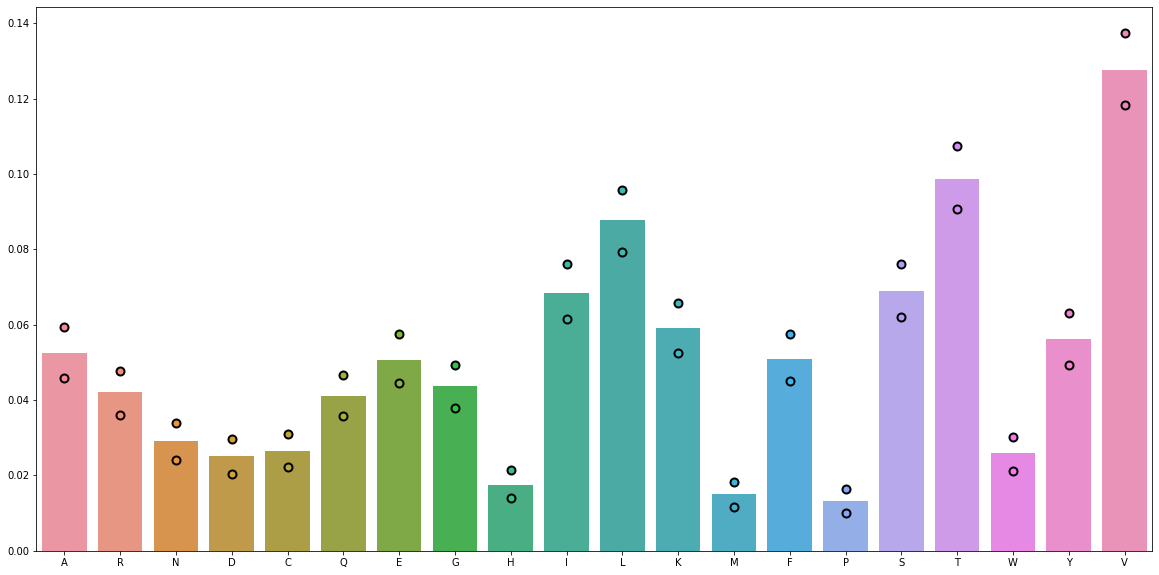

In [21]:
sandwich_freq_bootstrap = OrderedDict()
for aa in list(aa_dict.keys()):
    sandwich_freq_bootstrap[aa] = []

for n in range(1000):
    rows = []
    for m in range(sandwich_df.shape[0]-1):
        rows.append(random.randint(0, (sandwich_df.shape[0]-1)))
    copy_sandwich_df = copy.deepcopy(sandwich_df).iloc[rows].reset_index(drop=True)

    for aa in list(aa_dict.keys()):
        sandwich_freq_bootstrap[aa].append(
            copy_sandwich_df['fasta_seq'].tolist().count(aa) / copy_sandwich_df.shape[0]
        )

sandwich_freq_plot_data = OrderedDict({'FASTA': [],
                                       'Frequency': [],
                                       'Normalised frequency': [],
                                       'Lower percentile': [],
                                       'Upper percentile': []})
for aa in aa_dict.keys():
    sandwich_freq_plot_data['FASTA'].append(aa)
    sandwich_freq_plot_data['Frequency'].append(sandwich_df['fasta_seq'].tolist().count(aa))
    sandwich_freq_plot_data['Normalised frequency'].append(
        sandwich_df['fasta_seq'].tolist().count(aa) / sandwich_df.shape[0]
    )
    sandwich_freq_plot_data['Lower percentile'].append(np.percentile(sandwich_freq_bootstrap[aa], 2.5))
    sandwich_freq_plot_data['Upper percentile'].append(np.percentile(sandwich_freq_bootstrap[aa], 97.5))
    
plt.clf()
plt.figure(figsize=(20, 10))
sns.barplot(x='FASTA', y='Normalised frequency', data=sandwich_freq_plot_data)
sns.stripplot(
    x='FASTA', y='Lower percentile', data=sandwich_freq_plot_data, size=8, edgecolor='k', linewidth=2, jitter=False
)
sns.stripplot(
    x='FASTA', y='Upper percentile', data=sandwich_freq_plot_data, size=8, edgecolor='k', linewidth=2, jitter=False
)
plt.savefig('Amino_acid_distribution.svg')
plt.show()

In [22]:
pd.DataFrame(sandwich_freq_plot_data)

,FASTA,Frequency,Normalised frequency,Lower percentile,Upper percentile
0,A,251,0.052401,0.045939,0.059303
1,R,202,0.042171,0.036124,0.047823
2,N,139,0.029019,0.024222,0.034036
3,D,120,0.025052,0.020458,0.029651
4,C,127,0.026514,0.022134,0.031113
5,Q,197,0.041127,0.035707,0.046779
6,E,243,0.050731,0.044477,0.057423
7,G,209,0.043633,0.038004,0.049285
8,H,84,0.017537,0.013990,0.021508
9,I,328,0.068476,0.061391,0.076013


In [23]:
for aa in list(aa_dict.keys()):
    print(aa + ': ' + str(sandwich_df['fasta_seq'].tolist().count(aa)))
print('Total: {}'.format(sandwich_df.shape[0]))

A: 251
R: 202
N: 139
D: 120
C: 127
Q: 197
E: 243
G: 209
H: 84
I: 328
L: 421
K: 283
M: 72
F: 244
P: 63
S: 330
T: 473
W: 124
Y: 269
V: 611
Total: 4790


## Discrete propensity calculations

In [24]:
if not os.path.isdir('Discrete_propensities_indv_aas'):
    os.mkdir('Discrete_propensities_indv_aas')
os.chdir('Discrete_propensities_indv_aas')

### Edge/central propensity

In [25]:
edge_cen_propensity, edge_cen_frequency, edge_cen_normed_frequencies = calc_indv_property_propensities(
    sandwich_df, 'edge_or_central', aa_dict
)

In [26]:
edge_cen_propensity

,FASTA,central,edge
0,A,0.993130,1.010918
1,R,1.096922,0.845973
2,N,1.113517,0.819599
3,D,0.773895,1.359324
4,C,1.359848,0.428134
5,Q,0.868383,1.209164
6,E,0.838092,1.257302
7,G,1.161524,0.743308
8,H,0.911605,1.140476
9,I,1.033184,0.947264


In [27]:
edge_cen_frequency

,FASTA,central,edge
0,A,153,98
1,R,136,66
2,N,95,44
3,D,57,63
4,C,106,21
5,Q,105,92
6,E,125,118
7,G,149,60
8,H,47,37
9,I,208,120


<Figure size 432x288 with 0 Axes>

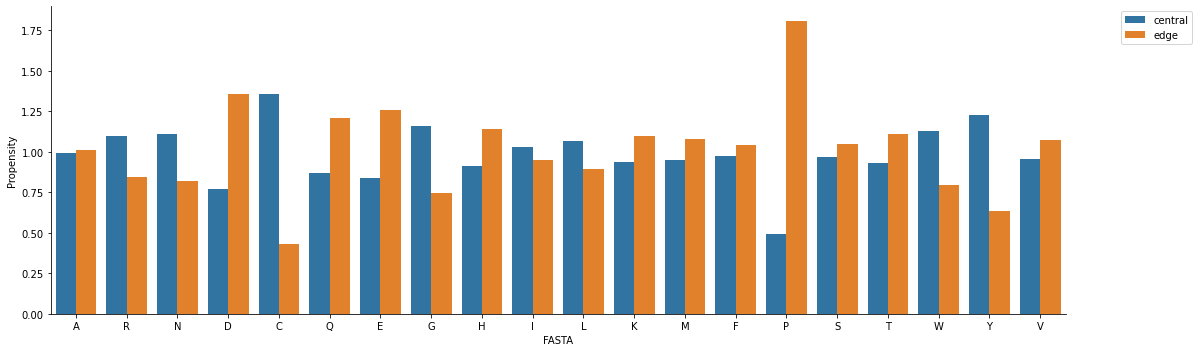

In [28]:
plot_bar_graphs(edge_cen_propensity, 'Propensity', True, 'Edge_cen_discrete_propensity')

<Figure size 432x288 with 0 Axes>

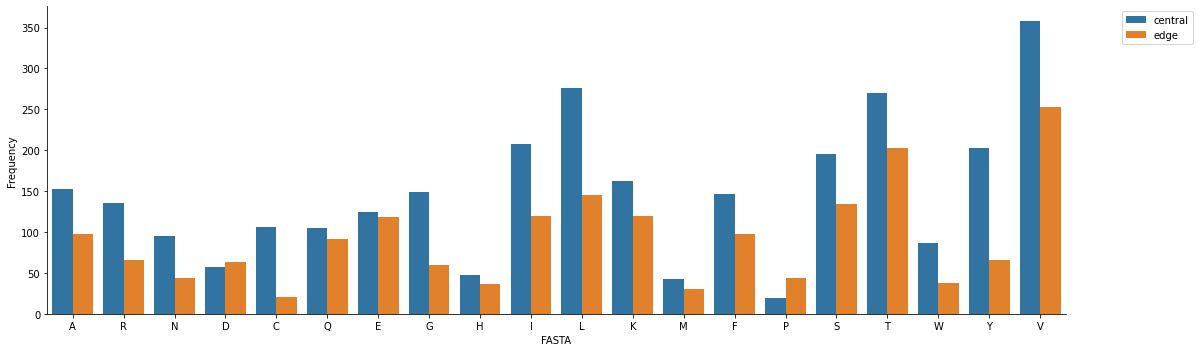

In [29]:
plot_bar_graphs(edge_cen_frequency, 'Frequency', True, 'Edge_cen_discrete_frequency')

In [30]:
(
    edge_cen_bootstrap_propensity_dict, edge_cen_bootstrap_frequency_dict
) = iterate_bootstrap_propensities(
    sandwich_df, sandwich_df, 'edge_or_central', aa_dict, [1000],
    calc_indv_property_propensities, edge_cen_propensity, edge_cen_frequency
)

1000


In [31]:
(
    edge_cen_conf_intv_propensity_dict, edge_cen_conf_intv_frequency_dict,
    edge_cen_conf_intv_normed_frequencies_dict
) = bootstrap_discrete_propensities(
    sandwich_df, sandwich_df, 'edge_or_central', aa_dict, 1000, calc_indv_property_propensities
)

<Figure size 432x288 with 0 Axes>

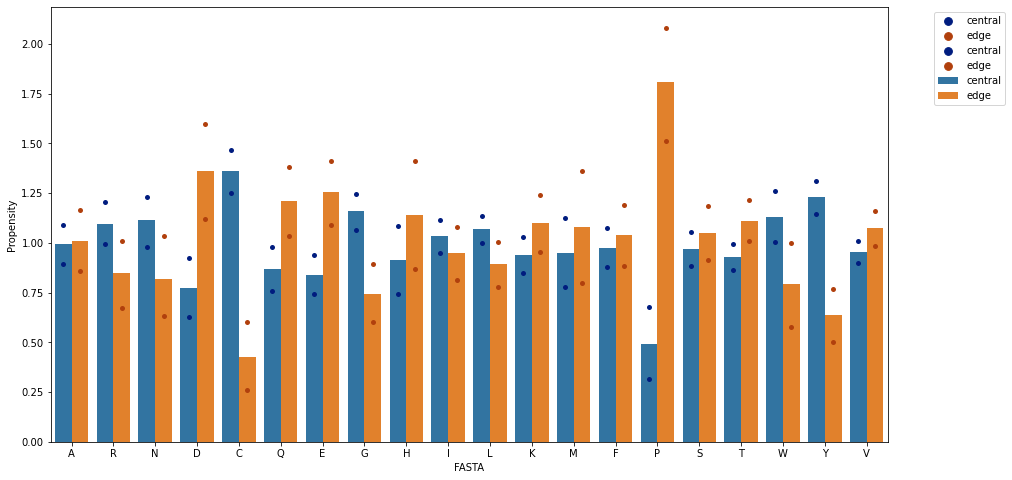

In [32]:
lower_percentile_edge_cen_propensity_dict, upper_percentile_edge_cen_propensity_dict = gen_95_conf_intervals(
    edge_cen_conf_intv_propensity_dict, 'Propensity'
)
plot_bar_graphs_with_conf_limits(
    edge_cen_propensity, lower_percentile_edge_cen_propensity_dict, upper_percentile_edge_cen_propensity_dict,
    'Propensity', True, 'Edge_cen_discrete_propensity_95_conf'
)

<Figure size 432x288 with 0 Axes>

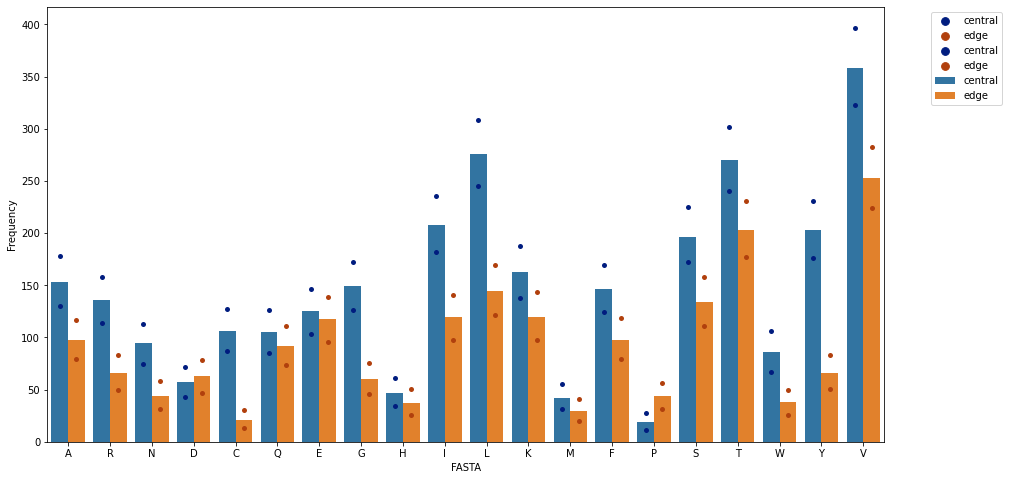

In [33]:
lower_percentile_edge_cen_frequency_dict, upper_percentile_edge_cen_frequency_dict = gen_95_conf_intervals(
    edge_cen_conf_intv_frequency_dict, 'Frequency'
)
plot_bar_graphs_with_conf_limits(
    edge_cen_frequency, lower_percentile_edge_cen_frequency_dict,
    upper_percentile_edge_cen_frequency_dict, 'Frequency', True, 'Edge_cen_discrete_frequency_95_conf'
)

### Core/surface propensity

In [34]:
core_surf_propensity, core_surf_frequency, core_surf_normed_frequencies = calc_indv_property_propensities(
    sandwich_df, 'core_surf', aa_dict
)

In [35]:
core_surf_propensity

,FASTA,surface,core
0,A,0.781638,1.391980
1,R,1.464574,0.166045
2,N,1.389044,0.301629
3,D,1.375415,0.326095
4,C,0.457236,1.974314
5,Q,1.343667,0.383084
6,E,1.416104,0.253054
7,G,1.220206,0.604708
8,H,1.334634,0.399299
9,I,0.602891,1.712849


In [36]:
core_surf_frequency

,FASTA,surface,core
0,A,126,125
1,R,190,12
2,N,124,15
3,D,106,14
4,C,37,89
5,Q,170,27
6,E,221,22
7,G,163,45
8,H,72,12
9,I,127,201


<Figure size 432x288 with 0 Axes>

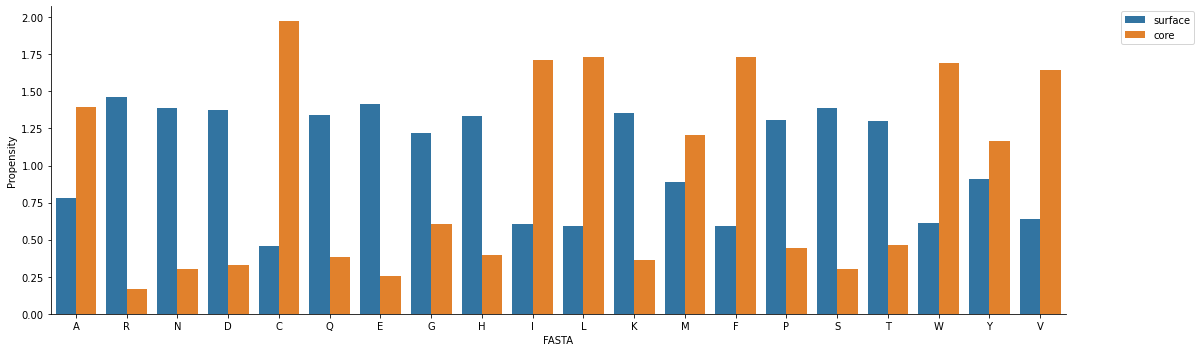

In [37]:
plot_bar_graphs(core_surf_propensity, 'Propensity', True, 'Core_surf_discrete_propensity')

<Figure size 432x288 with 0 Axes>

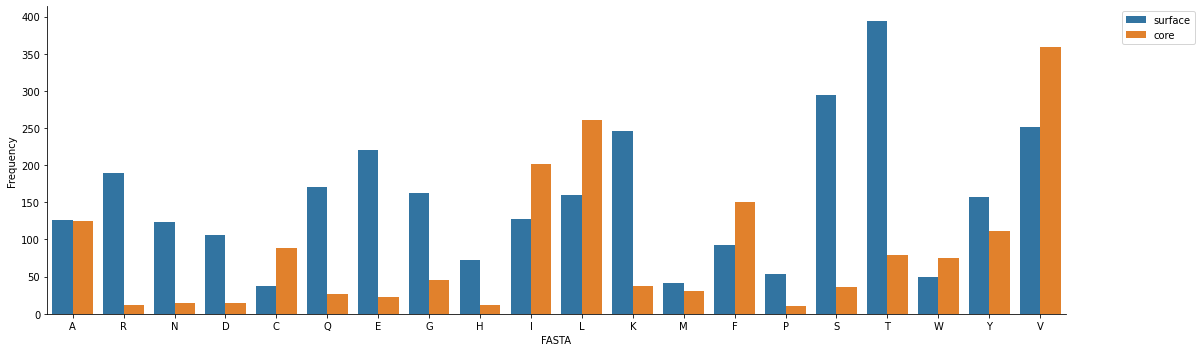

In [38]:
plot_bar_graphs(core_surf_frequency, 'Frequency', True, 'Core_surf_discrete_frequency')

In [39]:
(
    core_surf_bootstrap_propensity_dict, core_surf_bootstrap_frequency_dict
) = iterate_bootstrap_propensities(
    sandwich_df, sandwich_df, 'core_surf', aa_dict, [1000],
    calc_indv_property_propensities, core_surf_propensity, core_surf_frequency
)

1000


In [40]:
(
    core_surf_conf_intv_propensity_dict, core_surf_conf_intv_frequency_dict,
    core_surf_conf_intv_normed_frequencies_dict
) = bootstrap_discrete_propensities(
    sandwich_df, sandwich_df, 'core_surf', aa_dict, 1000, calc_indv_property_propensities
)

<Figure size 432x288 with 0 Axes>

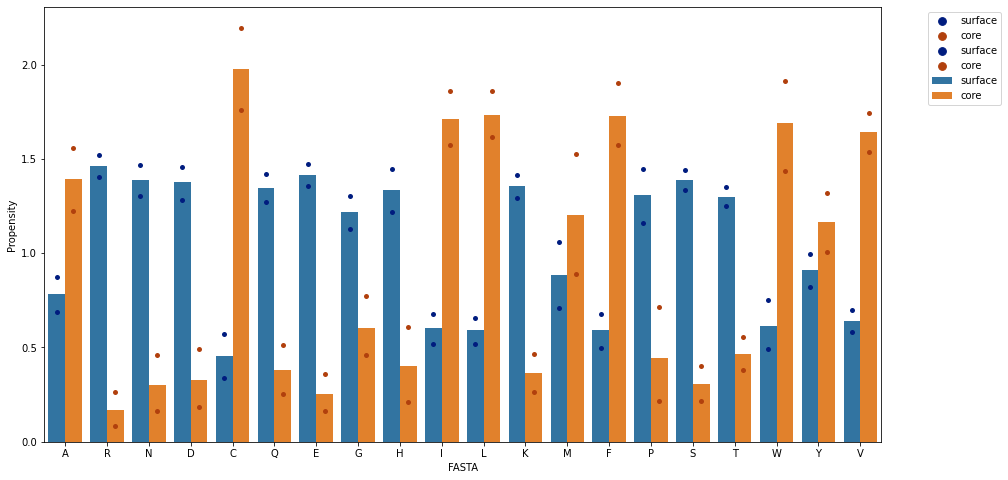

In [41]:
lower_percentile_core_surf_propensity_dict, upper_percentile_core_surf_propensity_dict = gen_95_conf_intervals(
    core_surf_conf_intv_propensity_dict, 'Propensity'
)
plot_bar_graphs_with_conf_limits(
    core_surf_propensity, lower_percentile_core_surf_propensity_dict, upper_percentile_core_surf_propensity_dict,
    'Propensity', True, 'Core_surf_discrete_propensity_95_conf'
)

<Figure size 432x288 with 0 Axes>

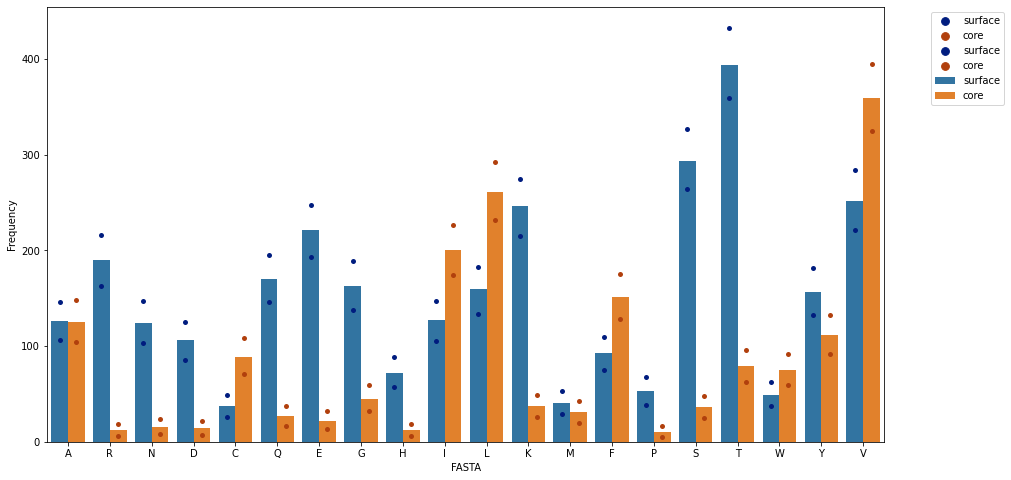

In [42]:
lower_percentile_core_surf_frequency_dict, upper_percentile_core_surf_frequency_dict = gen_95_conf_intervals(
    core_surf_conf_intv_frequency_dict, 'Frequency'
)
plot_bar_graphs_with_conf_limits(
    core_surf_frequency, lower_percentile_core_surf_frequency_dict, upper_percentile_core_surf_frequency_dict,
    'Frequency', True, 'Core_surf_discrete_frequency_95_conf'
)

### Core/surface and edge/central propensities

In [43]:
(core_surf_edge_cen_propensity, core_surf_edge_cen_frequency, core_surf_edge_cen_normed_frequencies
) = calc_combined_property_propensities(
    sandwich_df, ['core_surf', 'edge_or_central'], aa_dict
)

In [44]:
core_surf_edge_cen_propensity

,FASTA,surface_central,surface_edge,core_central,core_edge
0,A,0.767065,0.804882,1.401554,1.376892
1,R,1.642904,1.180148,0.113087,0.249505
2,N,1.603837,1.046462,0.230079,0.414388
3,D,1.076667,1.851899,0.228435,0.480000
4,C,0.562963,0.288608,2.791985,0.685714
5,Q,1.273096,1.456223,0.139148,0.767513
6,E,1.209328,1.745898,0.169211,0.385185
7,G,1.473718,0.815871,0.593053,0.623077
8,H,1.176190,1.587342,0.435115,0.342857
9,I,0.594715,0.615931,1.824695,1.536585


In [45]:
core_surf_edge_cen_frequency

,FASTA,surface_central,surface_edge,core_central,core_edge
0,A,76,50,77,48
1,R,131,59,5,7
2,N,88,36,7,8
3,D,51,55,6,8
4,C,28,9,77,12
5,Q,99,71,6,21
6,E,116,105,9,13
7,G,121,42,27,18
8,H,39,33,8,4
9,I,77,50,131,70


<Figure size 432x288 with 0 Axes>

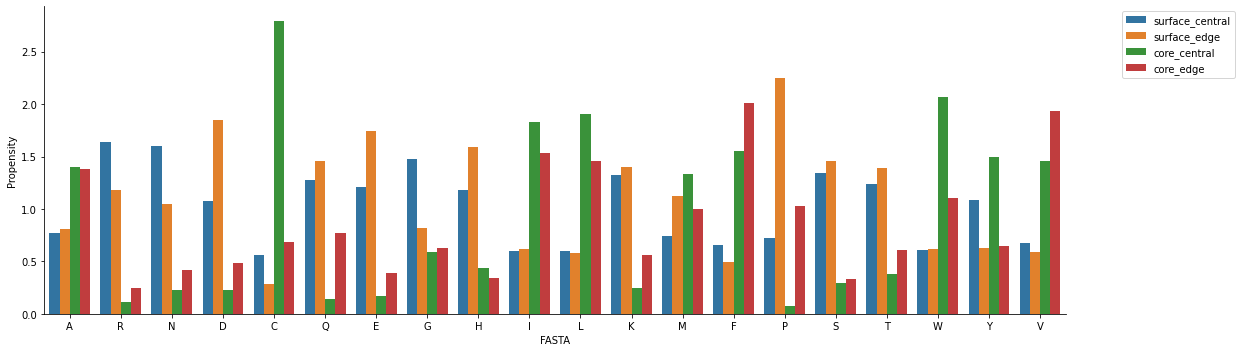

In [46]:
plot_bar_graphs(core_surf_edge_cen_propensity, 'Propensity', True, 'Core_surf_edge_cen_discrete_propensity')

<Figure size 432x288 with 0 Axes>

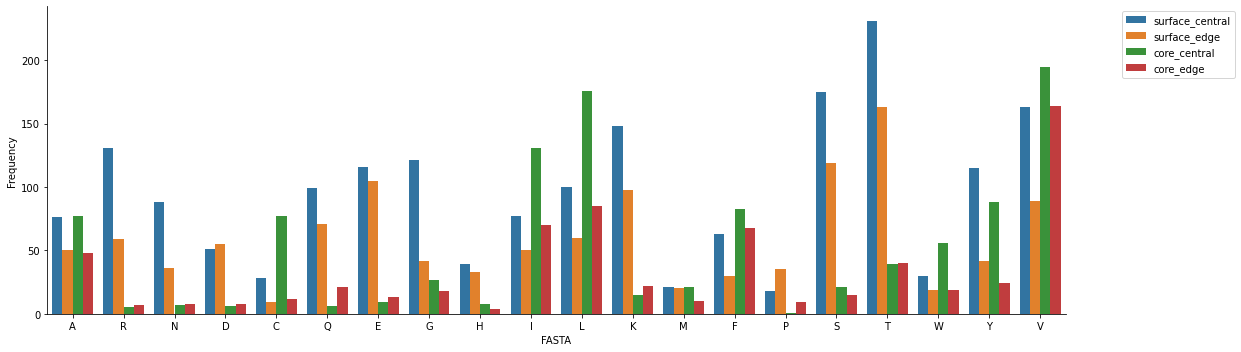

In [47]:
plot_bar_graphs(core_surf_edge_cen_frequency, 'Frequency', True, 'Core_surf_edge_cen_discrete_frequency')

In [48]:
(
    core_surf_edge_cen_bootstrap_propensity_dict, core_surf_edge_cen_bootstrap_frequency_dict
) = iterate_bootstrap_propensities(
    sandwich_df, sandwich_df, ['core_surf', 'edge_or_central'], aa_dict, [1000],
    calc_combined_property_propensities, core_surf_edge_cen_propensity, core_surf_edge_cen_frequency
)

1000


In [49]:
(
    core_surf_edge_cen_conf_intv_propensity_dict, core_surf_edge_cen_conf_intv_frequency_dict,
    core_surf_edge_cen_conf_intv_normed_frequencies_dict
) = bootstrap_discrete_propensities(
    sandwich_df, sandwich_df, ['core_surf', 'edge_or_central'], aa_dict, 1000,
    calc_combined_property_propensities
)

<Figure size 432x288 with 0 Axes>

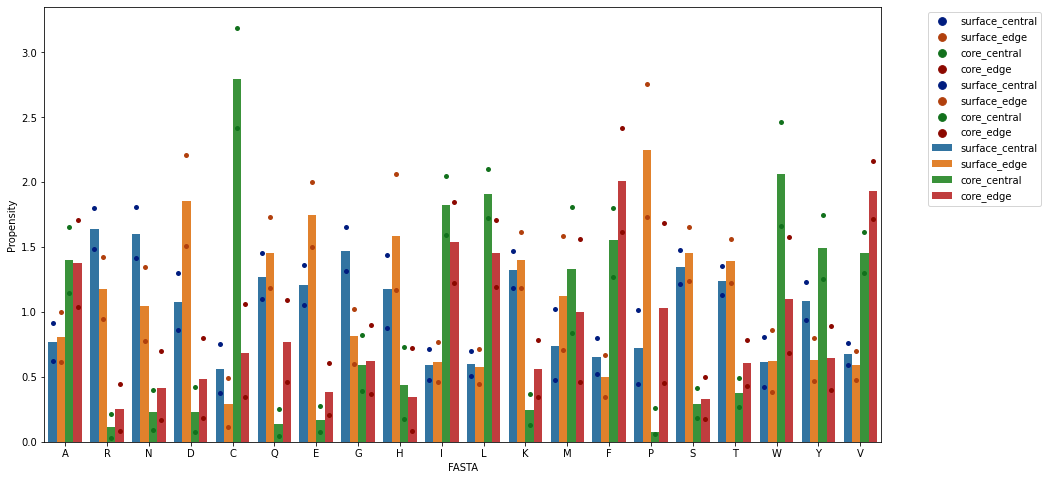

In [50]:
(
    lower_percentile_core_surf_edge_cen_propensity_dict, upper_percentile_core_surf_edge_cen_propensity_dict
) = gen_95_conf_intervals(
    core_surf_edge_cen_conf_intv_propensity_dict, 'Propensity'
)
plot_bar_graphs_with_conf_limits(
    core_surf_edge_cen_propensity, lower_percentile_core_surf_edge_cen_propensity_dict,
    upper_percentile_core_surf_edge_cen_propensity_dict, 'Propensity', True,
    'Core_surf_edge_cen_discrete_propensity_95_conf'
)

<Figure size 432x288 with 0 Axes>

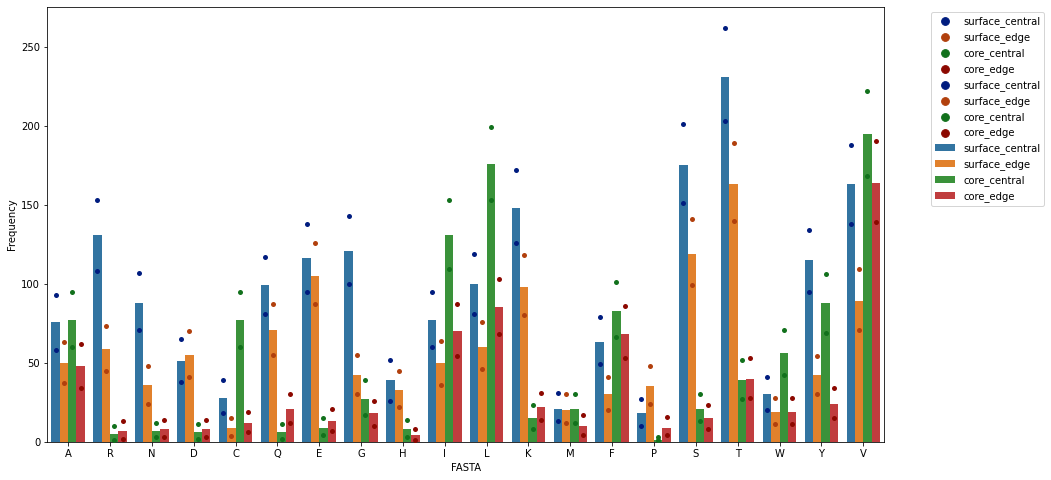

In [51]:
(
    lower_percentile_core_surf_edge_cen_frequency_dict, upper_percentile_core_surf_edge_cen_frequency_dict
) = gen_95_conf_intervals(
    core_surf_edge_cen_conf_intv_frequency_dict, 'Frequency'
)
plot_bar_graphs_with_conf_limits(
    core_surf_edge_cen_frequency, lower_percentile_core_surf_edge_cen_frequency_dict,
    upper_percentile_core_surf_edge_cen_frequency_dict, 'Frequency', True,
    'Core_surf_edge_cen_discrete_frequency_95_conf'
)

### Twist category (right/left-handed) propensities

HB pairs

In [52]:
hb_twist_propensity, hb_twist_frequency, hb_twist_normed_frequencies = calc_indv_property_propensities(
    sandwich_df, 'twist_hb_pairs', aa_dict
)

In [53]:
hb_twist_propensity

,FASTA,left,right
0,A,1.829895,0.937583
1,R,1.099696,0.992502
2,N,1.211530,0.984091
3,D,1.787007,0.940809
4,C,0.760428,1.018018
5,Q,0.564318,1.032768
6,E,1.361529,0.972809
7,G,2.808153,0.864008
8,H,0.997399,1.000196
9,I,0.845920,1.011588


In [54]:
hb_twist_frequency

,FASTA,left,right
0,A,16.0,109.0
1,R,8.0,96.0
2,N,5.0,54.0
3,D,5.0,35.0
4,C,5.0,89.0
5,Q,3.0,73.0
6,E,8.0,76.0
7,G,11.0,45.0
8,H,3.0,40.0
9,I,10.0,159.0


<Figure size 432x288 with 0 Axes>

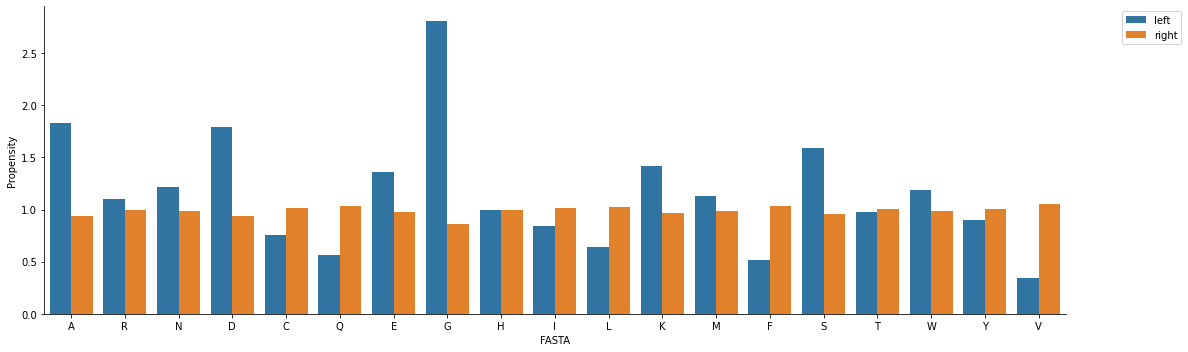

In [55]:
plot_bar_graphs(hb_twist_propensity, 'Propensity', True, 'HB_twist_discrete_propensity')

<Figure size 432x288 with 0 Axes>

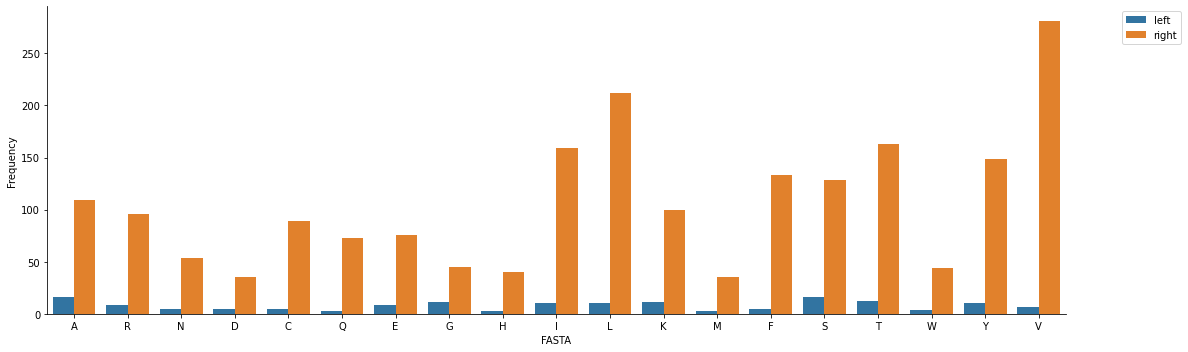

In [56]:
plot_bar_graphs(hb_twist_frequency, 'Frequency', True, 'HB_twist_discrete_frequency')

In [ ]:
(
    hb_twist_bootstrap_propensity_dict, hb_twist_bootstrap_frequency_dict
) = iterate_bootstrap_propensities(
    sandwich_df, sandwich_df, 'twist_hb_pairs', aa_dict, [1000],
    calc_indv_property_propensities, hb_twist_propensity, hb_twist_frequency
)

1000


In [ ]:
(
    hb_twist_conf_intv_propensity_dict, hb_twist_conf_intv_frequency_dict,
    hb_twist_conf_intv_normed_frequencies_dict
) = bootstrap_discrete_propensities(
    sandwich_df, sandwich_df, 'twist_hb_pairs', aa_dict, 1000, calc_indv_property_propensities
)

In [ ]:
(
    lower_percentile_hb_twist_propensity_dict, upper_percentile_hb_twist_propensity_dict
) = gen_95_conf_intervals(
    hb_twist_conf_intv_propensity_dict, 'Propensity'
)
plot_bar_graphs_with_conf_limits(
    hb_twist_propensity, lower_percentile_hb_twist_propensity_dict,
    upper_percentile_hb_twist_propensity_dict, 'Propensity', True, 'HB_twist_discrete_propensity_95_conf'
)

In [ ]:
(
    lower_percentile_hb_twist_frequency_dict, upper_percentile_hb_twist_frequency_dict
) = gen_95_conf_intervals(
    hb_twist_conf_intv_frequency_dict, 'Frequency'
)
plot_bar_graphs_with_conf_limits(
    hb_twist_frequency, lower_percentile_hb_twist_frequency_dict,
    upper_percentile_hb_twist_frequency_dict, 'Frequency', True, 'HB_twist_discrete_frequency_95_conf'
)

NHB pairs

In [ ]:
nhb_twist_propensity, nhb_twist_frequency, nhb_twist_normed_frequencies = calc_indv_property_propensities(
    sandwich_df, 'twist_nhb_pairs', aa_dict
)

In [ ]:
nhb_twist_propensity

In [ ]:
nhb_twist_frequency

In [ ]:
plot_bar_graphs(nhb_twist_propensity, 'Propensity', True, 'NHB_twist_discrete_propensity')

In [ ]:
plot_bar_graphs(nhb_twist_frequency, 'Frequency', True, 'NHB_twist_discrete_frequency')

In [ ]:
(
    nhb_twist_bootstrap_propensity_dict, nhb_twist_bootstrap_frequency_dict
) = iterate_bootstrap_propensities(
    sandwich_df, sandwich_df, 'twist_nhb_pairs', aa_dict, [1000],
    calc_indv_property_propensities, nhb_twist_propensity, nhb_twist_frequency
)

In [ ]:
(
    nhb_twist_conf_intv_propensity_dict, nhb_twist_conf_intv_frequency_dict,
    nhb_twist_conf_intv_normed_frequencies_dict
) = bootstrap_discrete_propensities(
    sandwich_df, sandwich_df, 'twist_nhb_pairs', aa_dict, 1000, calc_indv_property_propensities
)

In [ ]:
(
    lower_percentile_nhb_twist_propensity_dict, upper_percentile_nhb_twist_propensity_dict
) = gen_95_conf_intervals(
    nhb_twist_conf_intv_propensity_dict, 'Propensity'
)
plot_bar_graphs_with_conf_limits(
    nhb_twist_propensity, lower_percentile_nhb_twist_propensity_dict,
    upper_percentile_nhb_twist_propensity_dict, 'Propensity', True, 'NHB_twist_discrete_propensity_95_conf'
)

In [ ]:
(
    lower_percentile_nhb_twist_frequency_dict, upper_percentile_nhb_twist_frequency_dict
) = gen_95_conf_intervals(
    nhb_twist_conf_intv_frequency_dict, 'Frequency'
)
plot_bar_graphs_with_conf_limits(
    nhb_twist_frequency, lower_percentile_nhb_twist_frequency_dict,
    upper_percentile_nhb_twist_frequency_dict, 'Frequency', True, 'NHB_twist_discrete_frequency_95_conf'
)

### Defines core, surface, edge and central sub-dataframes

In [ ]:
core_sandwich_df = sandwich_df[sandwich_df['core_surf'] == 'core']
core_sandwich_df = core_sandwich_df.reset_index(drop=True)
print(core_sandwich_df.shape[0])

In [ ]:
surf_sandwich_df = sandwich_df[sandwich_df['core_surf'] == 'surface']
surf_sandwich_df = surf_sandwich_df.reset_index(drop=True)
print(surf_sandwich_df.shape[0])

In [ ]:
edge_sandwich_df = sandwich_df[sandwich_df['edge_or_central'] == 'edge']
edge_sandwich_df = edge_sandwich_df.reset_index(drop=True)
print(edge_sandwich_df.shape[0])

In [ ]:
cen_sandwich_df = sandwich_df[sandwich_df['edge_or_central'] == 'central']
cen_sandwich_df = cen_sandwich_df.reset_index(drop=True)
print(cen_sandwich_df.shape[0])

### Phi psi discrete bin propensities

Uniform bins

In [ ]:
phi_psi_sandwich_df = sandwich_df[['phi', 'psi']].dropna().reset_index(drop=True)
phi_psi_sandwich_df = phi_psi_sandwich_df[  (~phi_psi_sandwich_df['phi'].isin(['']))
                                      & (~phi_psi_sandwich_df['psi'].isin(['']))].reset_index(drop=True)
phi_psi_sandwich_df = phi_psi_sandwich_df.astype('float64')


bin_phi = np.arange(-180.0, 210.0, 30.0)
bin_psi = np.arange(-180.0, 210.0, 30.0)
counts = scipy.stats.binned_statistic_2d(
    phi_psi_sandwich_df['phi'], phi_psi_sandwich_df['psi'], None, 'count', bins=[bin_phi, bin_psi]
)

plt.clf()
plt.figure(figsize=(15,15))
sns.heatmap(np.flip(counts.statistic, axis=1), annot=True, fmt='g', cmap='seismic')
plt.savefig('Phi_psi_discrete_bins_uniform.svg')
plt.show()

Non-uniform bins

All sandwich residues

In [ ]:
discrete_phi_psi_cluster_coords, discrete_phi_psi_cluster_dataframe = calc_voronoi_points(
    sandwich_df, 'phi', 'psi', 100, True, 'Phi_psi_discrete_bins'
)

In [ ]:
vor = scipy.spatial.Voronoi(discrete_phi_psi_cluster_coords)

plt.clf()
fig = scipy.spatial.voronoi_plot_2d(vor, show_vertices=False)
fig.set_size_inches(10, 10)
plt.savefig('Phi_psi_discrete_bins_voronoi_points.svg')
plt.show()

In [ ]:
(discrete_phi_psi_propensity, discrete_phi_psi_frequency, discrete_phi_psi_normed_frequencies
) = calc_discrete_2d_indv_aa_propensities(sandwich_df, 'phi', 'psi', aa_dict, discrete_phi_psi_cluster_coords)

In [ ]:
discrete_phi_psi_propensity

In [ ]:
discrete_phi_psi_frequency

In [ ]:
plot_ramachandran_heat_map(
    discrete_phi_psi_propensity, discrete_phi_psi_cluster_coords, True, 'Ramachandran_propensity_plot'
)

In [ ]:
plot_ramachandran_heat_map(
    discrete_phi_psi_frequency, discrete_phi_psi_cluster_coords, True, 'Ramachandran_frequency_plot'
)

Core

In [ ]:
discrete_phi_psi_core_cluster_coords, discrete_phi_psi_core_cluster_dataframe = calc_voronoi_points(
    core_sandwich_df, 'phi', 'psi', 100
)

In [ ]:
core_vor = scipy.spatial.Voronoi(discrete_phi_psi_core_cluster_coords)

plt.clf()
fig = scipy.spatial.voronoi_plot_2d(core_vor, show_vertices=False)
fig.set_size_inches(10, 10)
plt.savefig('Core_phi_psi_discrete_bins_voronoi_points.svg')
plt.show()

In [ ]:
(discrete_phi_psi_core_propensity, discrete_phi_psi_core_frequency, discrete_phi_psi_core_normed_frequencies
) = calc_discrete_2d_indv_aa_propensities(
    core_sandwich_df, 'phi', 'psi', aa_dict, discrete_phi_psi_core_cluster_coords
)

In [ ]:
discrete_phi_psi_core_propensity

In [ ]:
discrete_phi_psi_core_frequency

In [ ]:
plot_ramachandran_heat_map(
    discrete_phi_psi_core_propensity, discrete_phi_psi_core_cluster_coords, True,
    'Core_Ramachandran_propensity_plot'
)

In [ ]:
plot_ramachandran_heat_map(
    discrete_phi_psi_core_frequency, discrete_phi_psi_core_cluster_coords, True,
    'Core_Ramachandran_frequency_plot'
)

Surface

In [ ]:
discrete_phi_psi_surf_cluster_coords, discrete_phi_psi_surf_cluster_dataframe = calc_voronoi_points(
    surf_sandwich_df, 'phi', 'psi', 100
)

In [ ]:
surf_vor = scipy.spatial.Voronoi(discrete_phi_psi_surf_cluster_coords)

plt.clf()
fig = scipy.spatial.voronoi_plot_2d(surf_vor, show_vertices=False)
fig.set_size_inches(10, 10)
plt.savefig('Surf_phi_psi_discrete_bins_voronoi_points.svg')
plt.show()

In [ ]:
(
    discrete_phi_psi_surf_propensity, discrete_phi_psi_surf_frequency, discrete_phi_psi_surf_normed_frequencies
) = calc_discrete_2d_indv_aa_propensities(
    surf_sandwich_df, 'phi', 'psi', aa_dict, discrete_phi_psi_surf_cluster_coords
)

In [ ]:
discrete_phi_psi_surf_propensity

In [ ]:
discrete_phi_psi_surf_frequency

In [ ]:
plot_ramachandran_heat_map(
    discrete_phi_psi_surf_propensity, discrete_phi_psi_surf_cluster_coords, True,
    'Surf_Ramachandran_propensity_plot'
)

In [ ]:
plot_ramachandran_heat_map(
    discrete_phi_psi_surf_frequency, discrete_phi_psi_surf_cluster_coords, True,
    'Surf_Ramachandran_frequency_plot'
)

Edge strands

In [ ]:
discrete_phi_psi_edge_cluster_coords, discrete_phi_psi_edge_cluster_dataframe = calc_voronoi_points(
    edge_sandwich_df, 'phi', 'psi', 100
)

In [ ]:
edge_vor = scipy.spatial.Voronoi(discrete_phi_psi_edge_cluster_coords)

plt.clf()
fig = scipy.spatial.voronoi_plot_2d(edge_vor, show_vertices=False)
fig.set_size_inches(10, 10)
plt.savefig('Edge_phi_psi_discrete_bins_voronoi_points.svg')
plt.show()

In [ ]:
(discrete_phi_psi_edge_propensity, discrete_phi_psi_edge_frequency, discrete_phi_psi_edge_normed_frequencies
) = calc_discrete_2d_indv_aa_propensities(
    edge_sandwich_df, 'phi', 'psi', aa_dict, discrete_phi_psi_edge_cluster_coords
)

In [ ]:
discrete_phi_psi_edge_propensity

In [ ]:
discrete_phi_psi_edge_frequency

In [ ]:
plot_ramachandran_heat_map(
    discrete_phi_psi_edge_propensity, discrete_phi_psi_edge_cluster_coords, True,
    'Edge_Ramachandran_propensity_plot'
)

In [ ]:
plot_ramachandran_heat_map(
    discrete_phi_psi_edge_frequency, discrete_phi_psi_edge_cluster_coords, True,
    'Edge_Ramachandran_frequency_plot'
)

Central strands

In [ ]:
discrete_phi_psi_cen_cluster_coords, discrete_phi_psi_cen_cluster_dataframe = calc_voronoi_points(
    cen_sandwich_df, 'phi', 'psi', 100
)

In [ ]:
cen_vor = scipy.spatial.Voronoi(discrete_phi_psi_cen_cluster_coords)

plt.clf()
fig = scipy.spatial.voronoi_plot_2d(cen_vor, show_vertices=False)
fig.set_size_inches(10, 10)
plt.savefig('Cen_phi_psi_discrete_bins_voronoi_points.svg')
plt.show()

In [ ]:
(
    discrete_phi_psi_cen_propensity, discrete_phi_psi_cen_frequency, discrete_phi_psi_cen_normed_frequencies
) = calc_discrete_2d_indv_aa_propensities(
    cen_sandwich_df, 'phi', 'psi', aa_dict, discrete_phi_psi_cen_cluster_coords
)

In [ ]:
discrete_phi_psi_cen_propensity

In [ ]:
discrete_phi_psi_cen_frequency

In [ ]:
plot_ramachandran_heat_map(
    discrete_phi_psi_cen_propensity, discrete_phi_psi_cen_cluster_coords, True,
    'Cen_Ramachandran_propensity_plot'
)

In [ ]:
plot_ramachandran_heat_map(
    discrete_phi_psi_cen_frequency, discrete_phi_psi_cen_cluster_coords, True,
    'Cen_Ramachandran_frequency_plot'
)

### Amino acid pairs propensities

In [ ]:
os.chdir('..')
if not os.path.isdir('Discrete_propensities_pairs_aas'):
    os.mkdir('Discrete_propensities_pairs_aas')
os.chdir('Discrete_propensities_pairs_aas')

#### Hydrogen bonding pairs

All sandwich residues

In [ ]:
hb_aa_pairs = gen_neighbouring_pairs_list(sandwich_df, sandwich_df, 'hb_pairs', aa_dict)
(hb_aa_pair_propensity, hb_aa_pair_frequency, hb_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(hb_aa_pairs, aa_dict)

In [ ]:
hb_aa_pair_propensity

In [ ]:
hb_aa_pair_frequency

In [ ]:
plot_heat_map(hb_aa_pair_propensity, True, 'HB_pairs_propensity')

In [ ]:
plot_heat_map(hb_aa_pair_frequency, True, 'HB_pairs_frequency')

Core

In [ ]:
hb_core_aa_pairs = gen_neighbouring_pairs_list(core_sandwich_df, sandwich_df, 'hb_pairs', aa_dict)
(hb_core_aa_pair_propensity, hb_core_aa_pair_frequency, hb_core_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(hb_core_aa_pairs, aa_dict)

In [ ]:
hb_core_aa_pair_propensity

In [ ]:
hb_core_aa_pair_frequency

In [ ]:
plot_heat_map(hb_core_aa_pair_propensity, True, 'Core_HB_pairs_propensity')

In [ ]:
plot_heat_map(hb_core_aa_pair_frequency, True, 'Core_HB_pairs_frequency')

Surface

In [ ]:
hb_surf_aa_pairs = gen_neighbouring_pairs_list(surf_sandwich_df, sandwich_df, 'hb_pairs', aa_dict)
(hb_surf_aa_pair_propensity, hb_surf_aa_pair_frequency, hb_surf_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(hb_surf_aa_pairs, aa_dict)

In [ ]:
hb_surf_aa_pair_propensity

In [ ]:
hb_surf_aa_pair_frequency

In [ ]:
plot_heat_map(hb_surf_aa_pair_propensity, True, 'Surf_HB_pairs_propensity')

In [ ]:
plot_heat_map(hb_surf_aa_pair_frequency, True, 'Surf_HB_pairs_frequency')

#### Non-hydrogen bonding pairs

All sandwich residues

In [ ]:
nhb_aa_pairs = gen_neighbouring_pairs_list(sandwich_df, sandwich_df, 'nhb_pairs', aa_dict)
(nhb_aa_pair_propensity, nhb_aa_pair_frequency, nhb_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(nhb_aa_pairs, aa_dict)

In [ ]:
nhb_aa_pair_propensity

In [ ]:
nhb_aa_pair_frequency

In [ ]:
plot_heat_map(nhb_aa_pair_propensity, True, 'NHB_pairs_propensity')

In [ ]:
plot_heat_map(nhb_aa_pair_frequency, True, 'NHB_pairs_frequency')

Core

In [ ]:
nhb_core_aa_pairs = gen_neighbouring_pairs_list(core_sandwich_df, sandwich_df, 'nhb_pairs', aa_dict)
(nhb_core_aa_pair_propensity, nhb_core_aa_pair_frequency, nhb_core_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(nhb_core_aa_pairs, aa_dict)

In [ ]:
nhb_core_aa_pair_propensity

In [ ]:
nhb_core_aa_pair_frequency

In [ ]:
plot_heat_map(nhb_core_aa_pair_propensity, True, 'Core_NHB_pairs_propensity')

In [ ]:
plot_heat_map(nhb_core_aa_pair_frequency, True, 'Core_NHB_pairs_frequency')

Surface

In [ ]:
nhb_surf_aa_pairs = gen_neighbouring_pairs_list(surf_sandwich_df, sandwich_df, 'nhb_pairs', aa_dict)
(nhb_surf_aa_pair_propensity, nhb_surf_aa_pair_frequency, nhb_surf_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(nhb_surf_aa_pairs, aa_dict)

In [ ]:
nhb_surf_aa_pair_propensity

In [ ]:
nhb_surf_aa_pair_frequency

In [ ]:
plot_heat_map(nhb_surf_aa_pair_propensity, True, 'Surf_NHB_pairs_propensity')

In [ ]:
plot_heat_map(nhb_surf_aa_pair_frequency, True, 'Surf_NHB_pairs_frequency')

#### Minus 2 pairs

All sandwich residues

In [ ]:
minus2_aa_pairs = gen_neighbouring_pairs_list(sandwich_df, sandwich_df, 'minus_2', aa_dict)
(minus2_aa_pair_propensity, minus2_aa_pair_frequency, minus2_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(minus2_aa_pairs, aa_dict)

In [ ]:
minus2_aa_pair_propensity

In [ ]:
minus2_aa_pair_frequency

In [ ]:
plot_heat_map(minus2_aa_pair_propensity, True, 'Minus2_pairs_propensity')

In [ ]:
plot_heat_map(minus2_aa_pair_frequency, True, 'Minus2_pairs_frequency')

Core

In [ ]:
minus2_core_aa_pairs = gen_neighbouring_pairs_list(core_sandwich_df, sandwich_df, 'minus_2', aa_dict)
(minus2_core_aa_pair_propensity, minus2_core_aa_pair_frequency, minus2_core_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(minus2_core_aa_pairs, aa_dict)

In [ ]:
minus2_core_aa_pair_propensity

In [ ]:
minus2_core_aa_pair_frequency

In [ ]:
plot_heat_map(minus2_core_aa_pair_propensity, True, 'Core_Minus2_pairs_propensity')

In [ ]:
plot_heat_map(minus2_core_aa_pair_frequency, True, 'Core_Minus2_pairs_frequency')

Surface

In [ ]:
minus2_surf_aa_pairs = gen_neighbouring_pairs_list(surf_sandwich_df, sandwich_df, 'minus_2', aa_dict)
(minus2_surf_aa_pair_propensity, minus2_surf_aa_pair_frequency, minus2_surf_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(minus2_surf_aa_pairs, aa_dict)

In [ ]:
minus2_surf_aa_pair_propensity

In [ ]:
minus2_surf_aa_pair_frequency

In [ ]:
plot_heat_map(minus2_surf_aa_pair_propensity, True, 'Surf_Minus2_pairs_propensity')

In [ ]:
plot_heat_map(minus2_surf_aa_pair_frequency, True, 'Surf_Minus2_pairs_frequency')

Edge strands

In [ ]:
minus2_edge_aa_pairs = gen_neighbouring_pairs_list(edge_sandwich_df, sandwich_df, 'minus_2', aa_dict)
(minus2_edge_aa_pair_propensity, minus2_edge_aa_pair_frequency, minus2_edge_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(minus2_edge_aa_pairs, aa_dict)

In [ ]:
minus2_edge_aa_pair_propensity

In [ ]:
minus2_edge_aa_pair_frequency

In [ ]:
plot_heat_map(minus2_edge_aa_pair_propensity, True, 'Edge_Minus2_pairs_propensity')

In [ ]:
plot_heat_map(minus2_edge_aa_pair_frequency, True, 'Edge_Minus2_pairs_frequency')

Central strands

In [ ]:
minus2_cen_aa_pairs = gen_neighbouring_pairs_list(cen_sandwich_df, sandwich_df, 'minus_2', aa_dict)
(minus2_cen_aa_pair_propensity, minus2_cen_aa_pair_frequency, minus2_cen_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(minus2_cen_aa_pairs, aa_dict)

In [ ]:
minus2_cen_aa_pair_propensity

In [ ]:
minus2_cen_aa_pair_frequency

In [ ]:
plot_heat_map(minus2_cen_aa_pair_propensity, True, 'Cen_Minus2_pairs_propensity')

In [ ]:
plot_heat_map(minus2_cen_aa_pair_frequency, True, 'Cen_Minus2_pairs_frequency')

#### Minus 1 pairs

All sandwich residues

In [ ]:
minus1_aa_pairs = gen_neighbouring_pairs_list(sandwich_df, sandwich_df, 'minus_1', aa_dict)
(minus1_aa_pair_propensity, minus1_aa_pair_frequency, minus1_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(minus1_aa_pairs, aa_dict)

In [ ]:
minus1_aa_pair_propensity

In [ ]:
minus1_aa_pair_frequency

In [ ]:
plot_heat_map(minus1_aa_pair_propensity, True, 'Minus1_pairs_propensity')

In [ ]:
plot_heat_map(minus1_aa_pair_frequency, True, 'Minus1_pairs_frequency')

Core

In [ ]:
minus1_core_aa_pairs = gen_neighbouring_pairs_list(core_sandwich_df, sandwich_df, 'minus_1', aa_dict)
(minus1_core_aa_pair_propensity, minus1_core_aa_pair_frequency, minus1_core_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(minus1_core_aa_pairs, aa_dict)

In [ ]:
minus1_core_aa_pair_propensity

In [ ]:
minus1_core_aa_pair_frequency

In [ ]:
plot_heat_map(minus1_core_aa_pair_propensity, True, 'Core_minus1_pairs_propensity')

In [ ]:
plot_heat_map(minus1_core_aa_pair_frequency, True, 'Core_minus1_pairs_frequency')

Surface

In [ ]:
minus1_surf_aa_pairs = gen_neighbouring_pairs_list(surf_sandwich_df, sandwich_df, 'minus_1', aa_dict)
(minus1_surf_aa_pair_propensity, minus1_surf_aa_pair_frequency, minus1_surf_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(minus1_surf_aa_pairs, aa_dict)

In [ ]:
minus1_surf_aa_pair_propensity

In [ ]:
minus1_surf_aa_pair_frequency

In [ ]:
plot_heat_map(minus1_surf_aa_pair_propensity, True, 'Surf_minus1_pairs_propensity')

In [ ]:
plot_heat_map(minus1_surf_aa_pair_frequency, True, 'Surf_minus1_pairs_frequency')

Edge strands

In [ ]:
minus1_edge_aa_pairs = gen_neighbouring_pairs_list(edge_sandwich_df, sandwich_df, 'minus_1', aa_dict)
(minus1_edge_aa_pair_propensity, minus1_edge_aa_pair_frequency, minus1_edge_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(minus1_edge_aa_pairs, aa_dict)

In [ ]:
minus1_edge_aa_pair_propensity

In [ ]:
minus1_edge_aa_pair_frequency

In [ ]:
plot_heat_map(minus1_edge_aa_pair_propensity, True, 'Edge_minus1_pairs_propensity')

In [ ]:
plot_heat_map(minus1_edge_aa_pair_frequency, True, 'Edge_minus1_pairs_frequency')

Central strands

In [ ]:
minus1_cen_aa_pairs = gen_neighbouring_pairs_list(cen_sandwich_df, sandwich_df, 'minus_1', aa_dict)
(minus1_cen_aa_pair_propensity, minus1_cen_aa_pair_frequency, minus1_cen_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(minus1_cen_aa_pairs, aa_dict)

In [ ]:
minus1_cen_aa_pair_propensity

In [ ]:
minus1_cen_aa_pair_frequency

In [ ]:
plot_heat_map(minus1_cen_aa_pair_propensity, True, 'Cen_minus1_pairs_propensity')

In [ ]:
plot_heat_map(minus1_cen_aa_pair_frequency, True, 'Cen_minus1_pairs_frequency')

#### Pairs in van der Waals contact

All sandwich residues

In [ ]:
vdw_aa_pairs = gen_neighbouring_pairs_list(sandwich_df, sandwich_df, 'van_der_waals', aa_dict)
(vdw_aa_pair_propensity, vdw_aa_pair_frequency, vdw_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(vdw_aa_pairs, aa_dict)

In [ ]:
vdw_aa_pair_propensity

In [ ]:
vdw_aa_pair_frequency

In [ ]:
plot_heat_map(vdw_aa_pair_propensity, True, 'VDW_pairs_propensity')

In [ ]:
plot_heat_map(vdw_aa_pair_frequency, True, 'VDW_pairs_frequency')

Core

In [ ]:
vdw_core_aa_pairs = gen_neighbouring_pairs_list(core_sandwich_df, sandwich_df, 'van_der_waals', aa_dict)
(vdw_core_aa_pair_propensity, vdw_core_aa_pair_frequency, vdw_core_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(vdw_core_aa_pairs, aa_dict)

In [ ]:
vdw_core_aa_pair_propensity

In [ ]:
vdw_core_aa_pair_frequency

In [ ]:
plot_heat_map(vdw_core_aa_pair_propensity, True, 'Core_VDW_pairs_propensity')

In [ ]:
plot_heat_map(vdw_core_aa_pair_frequency, True, 'Core_VDW_pairs_frequency')

Surface

In [ ]:
vdw_surf_aa_pairs = gen_neighbouring_pairs_list(surf_sandwich_df, sandwich_df, 'van_der_waals', aa_dict)
(vdw_surf_aa_pair_propensity, vdw_surf_aa_pair_frequency, vdw_surf_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(vdw_surf_aa_pairs, aa_dict)

In [ ]:
vdw_surf_aa_pair_propensity

In [ ]:
vdw_surf_aa_pair_frequency

In [ ]:
plot_heat_map(vdw_surf_aa_pair_propensity, True, 'Surf_VDW_pairs_propensity')

In [ ]:
plot_heat_map(plus2_surf_aa_pair_frequency, True, 'Surf_VDW_pairs_frequency')

Edge strands

In [ ]:
vdw_edge_aa_pairs = gen_neighbouring_pairs_list(edge_sandwich_df, sandwich_df, 'van_der_waals', aa_dict)
(vdw_edge_aa_pair_propensity, vdw_edge_aa_pair_frequency, vdw_edge_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(vdw_edge_aa_pairs, aa_dict)

In [ ]:
vdw_edge_aa_pair_propensity

In [ ]:
vdw_edge_aa_pair_frequency

In [ ]:
plot_heat_map(vdw_edge_aa_pair_propensity, True, 'Edge_VDW_pairs_propensity')

In [ ]:
plot_heat_map(vdw_edge_aa_pair_frequency, True, 'Edge_VDW_pairs_frequency')

Central strands

In [ ]:
vdw_cen_aa_pairs = gen_neighbouring_pairs_list(cen_sandwich_df, sandwich_df, 'van_der_waals', aa_dict)
(vdw_cen_aa_pair_propensity, vdw_cen_aa_pair_frequency, vdw_cen_aa_pair_normed_frequencies
) = calc_aa_pair_propensities(vdw_cen_aa_pairs, aa_dict)

In [ ]:
vdw_cen_aa_pair_propensity

In [ ]:
vdw_cen_aa_pair_frequency

In [ ]:
plot_heat_map(vdw_cen_aa_pair_propensity, True, 'Cen_VDW_pairs_propensity')

In [ ]:
plot_heat_map(plus2_cen_aa_pair_frequency, True, 'Cen_VDW_pairs_frequency')

## Continuous propensity calculations

In [ ]:
os.chdir('..')
if not os.path.isdir('Continuous_propensities_indv_aas'):
    os.mkdir('Continuous_propensities_indv_aas')
os.chdir('Continuous_propensities_indv_aas')

### 1D individual amino acid propensities

All sandwich residues

In [ ]:
plot_aa_kdes(sandwich_df, ['sandwich_z_coords'], 'comparison', aa_dict, True, 'sandwich_z_coord_dist')

In [ ]:
plot_bootstrap_aa_kdes(sandwich_df, 'sandwich_z_coords', aa_dict, 100, True, 'sandwich_z_coord_dist_100_bootstrap')

In [ ]:
z_sandwich_propensity = plot_1d_indv_aa_propensities(
    sandwich_df, 'sandwich_z_coords', aa_dict, 'True', 'sandwich_z_coord_propensity'
)

In [ ]:
plot_aa_kdes(sandwich_df, ['strand_z_coords'], 'comparison', aa_dict, True, 'strand_z_coord_dist')

In [ ]:
plot_bootstrap_aa_kdes(sandwich_df, 'strand_z_coords', aa_dict, 100, True, 'strand_z_coord_dist_100_bootstrap')

In [ ]:
z_strand_propensity = plot_1d_indv_aa_propensities(
    sandwich_df, 'strand_z_coords', aa_dict, True, 'strand_z_coord_propensity'
)

In [ ]:
plot_aa_kdes(sandwich_df, ['twist_angle_hb_pairs'], 'comparison', aa_dict, True, 'HB_twist_angle_dist')

In [ ]:
plot_bootstrap_aa_kdes(
    sandwich_df, 'twist_angle_hb_pairs', aa_dict, 100, True, 'HB_twist_angle_dist_100_bootstrap'
)

In [ ]:
twist_hb_propensity = plot_1d_indv_aa_propensities(
    sandwich_df, 'twist_angle_hb_pairs', aa_dict, True, 'HB_twist_angle_propensity'
)

In [ ]:
plot_aa_kdes(sandwich_df, ['twist_angle_nhb_pairs'], 'comparison', aa_dict, True, 'NHB_twist_angle_dist')

In [ ]:
plot_bootstrap_aa_kdes(
    sandwich_df, 'twist_angle_nhb_pairs', aa_dict, 100, True, 'NHB_twist_angle_dist_100_bootstrap'
)

In [ ]:
twist_nhb_propensity = plot_1d_indv_aa_propensities(
    sandwich_df, 'twist_angle_nhb_pairs', aa_dict, True, 'NHB_twist_angle_propensity'
)

Core

In [ ]:
plot_aa_kdes(core_sandwich_df, ['sandwich_z_coords'], 'comparison', aa_dict, True, 'Core_sandwich_z_coord_dist')

In [ ]:
plot_bootstrap_aa_kdes(
    core_sandwich_df, 'sandwich_z_coords', aa_dict, 100, True, 'Core_sandwich_z_coord_dist_100_bootstrap'
)

In [ ]:
z_sandwich_core_propensity = plot_1d_indv_aa_propensities(
    core_sandwich_df, 'sandwich_z_coords', aa_dict, True, 'Core_sandwich_z_coord_propensity'
)

In [ ]:
plot_aa_kdes(core_sandwich_df, ['strand_z_coords'], 'comparison', aa_dict, True, 'Core_strand_z_coord_dist')

In [ ]:
plot_bootstrap_aa_kdes(
    core_sandwich_df, 'strand_z_coords', aa_dict, 100, True, 'Core_strand_z_coord_dist_100_bootstrap'
)

In [ ]:
z_strand_core_propensity = plot_1d_indv_aa_propensities(
    core_sandwich_df, 'strand_z_coords', aa_dict, True, 'Core_strand_z_coord_propensity'
)

In [ ]:
plot_aa_kdes(core_sandwich_df, ['twist_angle_hb_pairs'], 'comparison', aa_dict, True, 'Core_HB_twist_angle_dist')

In [ ]:
plot_bootstrap_aa_kdes(
    core_sandwich_df, 'twist_angle_hb_pairs', aa_dict, 100, True, 'Core_HB_twist_angle_dist_100_bootstrap'
)

In [ ]:
core_twist_hb_propensity = plot_1d_indv_aa_propensities(
    core_sandwich_df, 'twist_angle_hb_pairs', aa_dict, True, 'Core_HB_twist_angle_propensity'
)

In [ ]:
plot_aa_kdes(core_sandwich_df, ['twist_angle_nhb_pairs'], 'comparison', aa_dict, True, 'Core_NHB_twist_angle_dist')

In [ ]:
plot_bootstrap_aa_kdes(
    core_sandwich_df, 'twist_angle_nhb_pairs', aa_dict, 100, True, 'Core_NHB_twist_angle_dist_100_bootstrap'
)

In [ ]:
core_twist_nhb_propensity = plot_1d_indv_aa_propensities(
    core_sandwich_df, 'twist_angle_nhb_pairs', aa_dict, True, 'Core_NHB_twist_angle_propensity'
)

Surface

In [ ]:
plot_aa_kdes(surf_sandwich_df, ['sandwich_z_coords'], 'comparison', aa_dict, True, 'Surf_sandwich_z_coord_dist')

In [ ]:
plot_bootstrap_aa_kdes(
    surf_sandwich_df, 'sandwich_z_coords', aa_dict, 100, True, 'Surf_sandwich_z_coord_dist_100_bootstrap'
)

In [ ]:
z_sandwich_surf_propensity = plot_1d_indv_aa_propensities(
    surf_sandwich_df, 'sandwich_z_coords', aa_dict, True, 'Surf_sandwich_z_coord_propensity'
)

In [ ]:
plot_aa_kdes(surf_sandwich_df, ['strand_z_coords'], 'comparison', aa_dict, True, 'Surf_strand_z_coord_dist')

In [ ]:
plot_bootstrap_aa_kdes(
    surf_sandwich_df, 'strand_z_coords', aa_dict, 100, True, 'Surf_strand_z_coord_dist_100_bootstrap'
)

In [ ]:
z_strand_surf_propensity = plot_1d_indv_aa_propensities(
    surf_sandwich_df, 'strand_z_coords', aa_dict, True, 'Surf_strand_z_coord_propensity'
)

In [ ]:
plot_aa_kdes(surf_sandwich_df, ['twist_angle_hb_pairs'], 'comparison', aa_dict, True, 'Surf_HB_twist_angle_dist')

In [ ]:
plot_bootstrap_aa_kdes(
    surf_sandwich_df, 'twist_angle_hb_pairs', aa_dict, 100, True, 'Surf_HB_twist_angle_dist_100_bootstrap'
)

In [ ]:
surf_twist_hb_propensity = plot_1d_indv_aa_propensities(
    surf_sandwich_df, 'twist_angle_hb_pairs', aa_dict, True, 'Surf_HB_twist_angle_propensity'
)

In [ ]:
plot_aa_kdes(surf_sandwich_df, ['twist_angle_nhb_pairs'], 'comparison', aa_dict, True, 'Surf_NHB_twist_angle_dist')

In [ ]:
plot_bootstrap_aa_kdes(
    surf_sandwich_df, 'twist_angle_nhb_pairs', aa_dict, 100, True, 'Surf_NHB_twist_angle_dist_100_bootstrap'
)

In [ ]:
surf_twist_nhb_propensity = plot_1d_indv_aa_propensities(
    surf_sandwich_df, 'twist_angle_nhb_pairs', aa_dict, True, 'Surf_NHB_twist_angle_propensity'
)

Edge strands

In [ ]:
plot_aa_kdes(edge_sandwich_df, ['sandwich_z_coords'], 'comparison', aa_dict, True, 'Edge_sandwich_z_coord_dist')

In [ ]:
plot_bootstrap_aa_kdes(
    edge_sandwich_df, 'sandwich_z_coords', aa_dict, 100, True, 'Edge_sandwich_z_coord_dist_100_bootstrap'
)

In [ ]:
z_sandwich_edge_propensity = plot_1d_indv_aa_propensities(
    edge_sandwich_df, 'sandwich_z_coords', aa_dict, True, 'Edge_sandwich_z_coord_propensity'
)

In [ ]:
plot_aa_kdes(edge_sandwich_df, ['strand_z_coords'], 'comparison', aa_dict, True, 'Edge_strand_z_coord_dist')

In [ ]:
plot_bootstrap_aa_kdes(
    edge_sandwich_df, 'strand_z_coords', aa_dict, 100, True, 'Edge_strand_z_coord_dist_100_bootstrap'
)

In [ ]:
z_strand_edge_propensity = plot_1d_indv_aa_propensities(
    edge_sandwich_df, 'strand_z_coords', aa_dict, True, 'Edge_strand_z_coord_propensity'
)

Central strands

In [ ]:
plot_aa_kdes(cen_sandwich_df, ['sandwich_z_coords'], 'comparison', aa_dict, True, 'Cen_sandwich_z_coord_dist')

In [ ]:
plot_bootstrap_aa_kdes(
    cen_sandwich_df, 'sandwich_z_coords', aa_dict, 100, True, 'Cen_sandwich_z_coord_dist_100_bootstrap'
)

In [ ]:
z_sandwich_cen_propensity = plot_1d_indv_aa_propensities(
    cen_sandwich_df, 'sandwich_z_coords', aa_dict, True, 'Cen_sandwich_z_coord_propensity'
)

In [ ]:
plot_aa_kdes(cen_sandwich_df, ['strand_z_coords'], 'comparison', aa_dict, True, 'Cen_strand_z_coord_dist')

In [ ]:
plot_bootstrap_aa_kdes(
    cen_sandwich_df, 'strand_z_coords', aa_dict, 100, True, 'Cen_strand_z_coord_dist_100_bootstrap'
)

In [ ]:
z_strand_cen_propensity = plot_1d_indv_aa_propensities(
    cen_sandwich_df, 'strand_z_coords', aa_dict, True, 'Cen_strand_z_coord_propensity'
)

## Saves propensity dictionaries to pickle file

In [ ]:
os.chdir('../..')

In [ ]:
# May need to update BetaDesigner to work with core/surf rather than int/ext
propensities_dict = OrderedDict({'core_-_-_-_indv_disc_propensity': core_surf_propensity.loc[:, ['FASTA', 'core']],
                                 'surf_-_-_-_indv_disc_propensity': core_surf_propensity.loc[:, ['FASTA', 'surface']],
                                 '-_edg_-_-_indv_disc_propensity': edge_cen_propensity.loc[:, ['FASTA', 'edge']],
                                 '-_cen_-_-_indv_disc_propensity': edge_cen_propensity.loc[:, ['FASTA', 'central']],
                                 '-_-_-_hb_pair_disc_propensity': hb_aa_pair_propensity,
                                 '-_-_-_nhb_pair_disc_propensity': nhb_aa_pair_propensity,
                                 '-_-_-_plusminus2_pair_disc_propensity': minus2_aa_pair_propensity,
                                 '-_-_-_plusminus1_pair_disc_propensity': minus1_aa_pair_propensity,
                                 '-_-_-_vdw_pair_disc_propensity': vdw_aa_pair_propensity,
                                 '-_-_zsandwich_-_indv_cont_propensity': z_sandwich_propensity,
                                 '-_-_phipsi_-_indv_disc_propensity': discrete_phi_psi_propensity})

with open('Pickled_sandwich_propensity_dictionaries.pkl', 'wb') as pickle_file:
    pickle.dump(propensities_dict, pickle_file)

In [ ]:
frequencies_dict = OrderedDict({'core_-_-_-_indv_disc_frequency': core_surf_normed_frequencies.loc[:, ['FASTA', 'core']],
                                'surf_-_-_-_indv_disc_frequency': core_surf_normed_frequencies.loc[:, ['FASTA', 'surface']],
                                '-_edg_-_-_indv_disc_frequency': edge_cen_normed_frequencies.loc[:, ['FASTA', 'edge']],
                                '-_cen_-_-_indv_disc_frequency': edge_cen_normed_frequencies.loc[:, ['FASTA', 'central']],
                                '-_-_-_hb_pair_disc_frequency': hb_aa_pair_normed_frequencies,
                                '-_-_-_nhb_pair_disc_frequency': nhb_aa_pair_normed_frequencies,
                                '-_-_-_plusminus2_pair_disc_frequency': minus2_aa_pair_normed_frequencies,
                                '-_-_-_plusminus1_pair_disc_frequency': minus1_aa_pair_normed_frequencies,
                                '-_-_-_vdw_pair_disc_frequency': vdw_aa_pair_normed_frequencies,
                                '-_-_phipsi_-_indv_disc_frequency': discrete_phi_psi_normed_frequencies})

with open('Pickled_sandwich_frequency_dictionaries.pkl', 'wb') as pickle_file:
    pickle.dump(frequencies_dict, pickle_file)

In [ ]:
cluster_coords_dict = OrderedDict({'all_surfaces': discrete_phi_psi_cluster_coords})
with open('Pickled_phi_psi_sandwich_cluster_coords.pkl', 'wb') as pickle_file:
    pickle.dump((cluster_coords_dict), pickle_file)

Check no change to dataframe shape during analysis

In [ ]:
sandwich_df.shape